In [1]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import random 
import itertools

from IPython.display import display, HTML, Markdown

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

2025-04-28 15:06:27.912303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745827587.924763  105404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745827587.928433  105404 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 15:06:27.943796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'height',
                'weight',
                'systolic', 
                'diastolic',
                'bmi',
                'map',
                'pulse_pressure',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [3]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age    height    weight  systolic  diastolic       bmi       map  \
0 -0.431181 -0.580958  0.227592 -0.448449  -0.219513  0.556238 -0.357337   
1  1.645896 -0.050963  0.146374 -0.448449  -1.522162  0.164370 -1.087684   
2 -1.766444  0.479031 -0.503370 -1.149304  -1.522162 -0.739102 -1.453955   
3 -1.469719  0.611530  1.933169  1.303690   1.734461  1.485835  1.653859   
4 -0.134455  1.009026  0.146374 -0.448449  -0.219513 -0.388598 -0.357337   

   pulse_pressure  gender  cholesterol  gluc  smoke  alco  active  
0       -0.453476     0.0          0.0   0.0    0.0   0.0     0.0  
1        0.508610     0.0          0.0   0.0    0.0   0.0     0.0  
2       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  
3        0.508610     1.0          0.0   0.0    1.0   1.0     1.0  
4       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  


In [4]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=None, lr=None, batch_size=None, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self



SUMMARY_HISTORY_TEST = []
SUMMARY_HISTORY_TRAIN = []

# — Style dicts for plotting —
JOURNAL_STYLE = {
    "font.family":     "serif",
    "font.serif":      ["Times New Roman", "CMU Serif"],
    "figure.dpi":      300,
    "axes.titlesize":  12,
    "axes.labelsize":  10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth":  1.0,
}

ACC_STYLE = {
    **JOURNAL_STYLE,
    "axes.linewidth":  0.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
}

def _style_ax(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    
def evaluate_model(
    model,
    model_name="",
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=target_names,
    roc_auc=False,
    fit=False,
    summary=False,
    plot_cm_roc=False,
    plot_acc=False
):
    """
    fit=True     -> call model.fit(x_train, y_train) internally
    fit=False    -> assume model is already fitted externally
    summary=False-> only save summary data without printing
    summary=True -> display cumulative summary tables as HTML
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score
    
    # 1) Fit the model if requested
    if fit:
        model.fit(x_train, y_train)

    # 2) Make predictions & predict probabilities
    y_pred_train  = model.predict(x_train)
    y_pred_test   = model.predict(x_test)
    y_proba_train = model.predict_proba(x_train)[:, 1]
    y_proba_test  = model.predict_proba(x_test)[:, 1]

    # 3) Compute metrics for both Train and Test
    metrics = {}
    for split, y_true, y_pred, y_probs in [
        ("Train", y_train, y_pred_train, y_proba_train),
        ("Test",  y_test,  y_pred_test,  y_proba_test)
    ]:
        metrics[f"{split}_Acc"]       = accuracy_score(y_true, y_pred)
        metrics[f"{split}_AUC"]       = roc_auc_score(y_true, y_probs)
        rpt = classification_report(y_true, y_pred, output_dict=True)
        metrics[f"{split}_Precision"] = rpt["weighted avg"]["precision"]
        metrics[f"{split}_Recall"]    = rpt["weighted avg"]["recall"]
        metrics[f"{split}_F1"]        = rpt["weighted avg"]["f1-score"]

    # 4) Print detailed classification reports with centered title
    BOLD, RESET = "\033[1m", "\033[0m"
    title = f"=== {model_name} Results ==="
    print("\n" + BOLD + title.center(60) + RESET)
    for split in ("Test", "Train"):
        print(f"{split} Acc: {metrics[f'{split}_Acc']:.4f}, AUC: {metrics[f'{split}_AUC']:.4f}")
        print(classification_report(
            y_test if split=="Test" else y_train,
            y_pred_test if split=="Test" else y_pred_train,
            digits=4
        ))
    print(
        "✅ No significant overfitting\n"
        if not (
            metrics["Train_Acc"] > metrics["Test_Acc"] + 0.05
            or metrics["Train_AUC"] > metrics["Test_AUC"] + 0.05
        )
        else "⚠️ Overfitting suspected\n"
    )

    # 5) Append current metrics to history lists
    SUMMARY_HISTORY_TEST[:]  = [
        d for d in SUMMARY_HISTORY_TEST  if d["Algorithm"] != model_name
    ]
    SUMMARY_HISTORY_TRAIN[:] = [
        d for d in SUMMARY_HISTORY_TRAIN if d["Algorithm"] != model_name
    ]

    # Lalu append yang baru
    SUMMARY_HISTORY_TEST.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Test_Acc"],
        "Precision": metrics["Test_Precision"],
        "Recall":    metrics["Test_Recall"],
        "F1-Score":  metrics["Test_F1"],
        "AUC":       metrics["Test_AUC"]
    })
    SUMMARY_HISTORY_TRAIN.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Train_Acc"],
        "Precision": metrics["Train_Precision"],
        "Recall":    metrics["Train_Recall"],
        "F1-Score":  metrics["Train_F1"],
        "AUC":       metrics["Train_AUC"]
    })

    # 6) Display cumulative summary tables as HTML when requested
    if summary:
        import pandas as pd
        from IPython.display import display, HTML

        df_test  = pd.DataFrame(SUMMARY_HISTORY_TEST)
        df_train = pd.DataFrame(SUMMARY_HISTORY_TRAIN)

        if isinstance(summary, dict):
            keep = [model_name] + list(summary.keys())
        else:
            keep = [model_name]

        df_test  = df_test[df_test["Algorithm"].isin(keep)]
        df_train = df_train[df_train["Algorithm"].isin(keep)]

        display(HTML(
            "<h4>Cumulative Summary Table – Test Metrics</h4>"
            + df_test.to_html(index=False, float_format="%.4f")
        ))
        display(HTML(
            "<h4>Cumulative Summary Table – Train Metrics</h4>"
            + df_train.to_html(index=False, float_format="%.4f")
        ))
        
    # 7) Plot Confusion Matrix & ROC Curves if requested
    if plot_cm_roc:
        plt.rcParams.update(JOURNAL_STYLE)
        labels = list(label_mapping) if label_mapping is not None else ["0","1"]
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        def _plot_cm(ax, y_t, y_p, title):
            disp = ConfusionMatrixDisplay(
                confusion_matrix(y_t, y_p), display_labels=labels
            )
            disp.plot(
                ax=ax,
                values_format='d',
                cmap="Blues",
                colorbar=True,
                text_kw={"fontsize": 12}
            )
            n = len(labels)
            ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
            ax.grid(which='minor', color='black', linestyle='-')  # fine for cell borders

            # === REMOVE THOSE DASHED HORIZONTAL LINES ===
            ax.grid(False)  # turn _off_ all grid lines
            # Or if you want only the vertical cell borders, do:
            # ax.grid(axis='x', which='minor', color='black', linestyle='-')
            ax.tick_params(which='minor', length=0)

            ax.set_title(f"{model_name} – {title}")
            ax.set_xlabel("Predicted label")
            ax.set_ylabel("True label")

            # keep your spine styling
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

        def _plot_roc(ax, y_t, y_p, title, auc_val):
            fpr, tpr, _ = roc_curve(y_t, y_p)
            ax.plot(fpr, tpr, lw=2, label=f"AUC = {auc_val:.4f}")
            ax.plot([0,1], [0,1], "--", lw=1, color="gray")
            ax.set_title(f"{model_name} – {title}")
            ax.set_xlabel("False Positive Rate (FPR)")
            ax.set_ylabel("True Positive Rate (TPR)")
            ax.legend(frameon=True, loc="lower right")
            _style_ax(ax)

        _plot_cm(axes[0,0], y_train,      y_pred_train,  "Confusion Matrix (Train)")
        _plot_roc(axes[0,1], y_train,      y_proba_train, "ROC Curve (Train)", metrics["Train_AUC"])
        _plot_cm(axes[1,0], y_test,       y_pred_test,   "Confusion Matrix (Test)")
        _plot_roc(axes[1,1], y_test,       y_proba_test,  "ROC Curve (Test)",  metrics["Test_AUC"])

        plt.tight_layout()
        plt.show()

    # 8) ROC Comparison (boolean or dict)
    if roc_auc:
        plt.rcParams.update(JOURNAL_STYLE)

        # 1) Decide which models to include
        if isinstance(roc_auc, dict):
            # first the extra models, then the primary one
            roc_items = list(roc_auc.items()) + [(model_name, model)]
        else:
            # only the primary model
            roc_items = [(model_name, model)]

        n_models = len(roc_items)
        base_tick     = 10
        tick_fontsize = max(6,  base_tick - n_models//2)
        title_fontsize= max(10, base_tick + 2 - n_models//2)
        label_fontsize= max(8,  base_tick - n_models//3)
        legend_fontsize = max(6, base_tick - n_models//2)

        fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

        # 2) Plot extra models with thinner lines
        for nm, m in roc_items[:-1]:
            pr = m.predict_proba(x_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, pr)
            auc_val = roc_auc_score(y_test, pr)
            ax.plot(fpr, tpr, lw=1.5, label=f"{nm} (AUC={auc_val:.4f})")

        # 3) Plot primary model with thicker line
        main_label = roc_items[-1][0]
        ax.plot(
            *roc_curve(y_test, y_proba_test)[:2],
            lw=2,
            label=f"{main_label} (AUC={metrics['Test_AUC']:.4f})"
        )

        # 4) Diagonal reference and styling (unchanged)
        ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray")
        ax.set_xlabel("False Positive Rate (FPR)", labelpad=4, fontsize=label_fontsize)
        ax.set_ylabel("True Positive Rate (TPR)",  labelpad=4, fontsize=label_fontsize)
        ax.set_title("ROC Curve Comparison", pad=6,     fontsize=title_fontsize)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)

        # 5) Legend with background
        ax.legend(
            frameon=True,
            facecolor="white",
            edgecolor="black",
            framealpha=0.9,
            loc="lower right",
            fontsize=legend_fontsize
        )

        plt.show()
        
    # 9) Plot Accuracy bar chart (boolean or dict)
    if plot_acc:
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.metrics import accuracy_score
        import torch

        plt.rcParams.update(ACC_STYLE)

        # 1) Decide which algos to plot
        if isinstance(plot_acc, dict):
            names, models = zip(*(list(plot_acc.items()) + [(model_name, model)]))
        elif plot_acc is True:
            names, models = [model_name], [model]
        else:
            return metrics  # Skip plotting if plot_acc is False

        # 2) Compute accuracies
        train_acc = []
        test_acc  = []
        for m in models:
            if hasattr(m, "predict"):
                y_tr, y_te = m.predict(x_train), m.predict(x_test)
            else:
                m.eval()
                with torch.no_grad():
                    y_tr = (m(torch.tensor(x_train, dtype=torch.float32)).squeeze()>0.5).long().numpy()
                    y_te = (m(torch.tensor(x_test,  dtype=torch.float32)).squeeze()>0.5).long().numpy()
            train_acc.append(accuracy_score(y_train, y_tr))
            test_acc.append(accuracy_score(y_test,  y_te))

        # 3) Plot settings
        n     = len(names)
        gap   = 1.0                       # space between groups
        w     = gap * 0.4                # bar width = 40% of gap
        x     = np.arange(n) * gap
        fig, ax = plt.subplots(figsize=(max(6, n*gap*0.6), 4))

        bars_tr = ax.bar(x - w/2, train_acc, w,
                        label="Train", color="#4C72B0",
                        edgecolor="black", linewidth=0.8)
        bars_te = ax.bar(x + w/2, test_acc,  w,
                        label="Test",  color="#55A868",
                        edgecolor="black", linewidth=0.8)
        from matplotlib.patches import Rectangle

        # 4) Draw one box per group, then two colored texts inside
        ax.set_ylim(0, 1.15)  # tambah headroom

        for xi, tr, te in zip(x, train_acc, test_acc):
            # ukuran & posisi kotak
            box_w = w * 1.8
            box_h = 0.07
            y0    = max(tr, te) + 0.02

            # gambar kotak putih dengan border abu
            rect = Rectangle(
                (xi - box_w/2, y0),
                box_w, box_h,
                facecolor="white",
                edgecolor="gray",
                linewidth=0.8,
                clip_on=False
            )
            ax.add_patch(rect)

            # Train text (biru) di bagian atas kotak
            ax.text(
                xi, y0 + box_h * 0.7,
                f"{tr*100:.2f}%",
                ha="center", va="center",
                color="#4C72B0",
                fontsize=6,
                fontweight="bold",
                clip_on=False
            )
            # Test text (hijau) di bagian bawah kotak
            ax.text(
                xi, y0 + box_h * 0.3,
                f"{te*100:.2f}%",
                ha="center", va="center",
                color="#55A868",
                fontsize=6,
                fontweight="bold",
                clip_on=False
            )

        # 5) Styling axes & legend utama
        tick_fs = max(6, 10 - n//2)
        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=45, ha="right", fontsize=tick_fs)
        ax.set_ylabel("Accuracy (%)", fontsize=tick_fs + 1)
        ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=True, loc="upper left", fontsize=tick_fs)

        plt.tight_layout()
        plt.show()


    return metrics

# Clear histories before first run
# SUMMARY_HISTORY_TRAIN.clear()
# SUMMARY_HISTORY_TEST.clear()


                 === LightGBM1 Results ===                  
Test Acc: 0.7382, AUC: 0.8016
              precision    recall  f1-score   support

           0     0.7256    0.7755    0.7497      6321
           1     0.7530    0.7000    0.7255      6180

    accuracy                         0.7382     12501
   macro avg     0.7393    0.7378    0.7376     12501
weighted avg     0.7391    0.7382    0.7378     12501

Train Acc: 0.7440, AUC: 0.8187
              precision    recall  f1-score   support

           0     0.7290    0.7870    0.7569     25313
           1     0.7622    0.7000    0.7298     24688

    accuracy                         0.7440     50001
   macro avg     0.7456    0.7435    0.7433     50001
weighted avg     0.7454    0.7440    0.7435     50001

✅ No significant overfitting



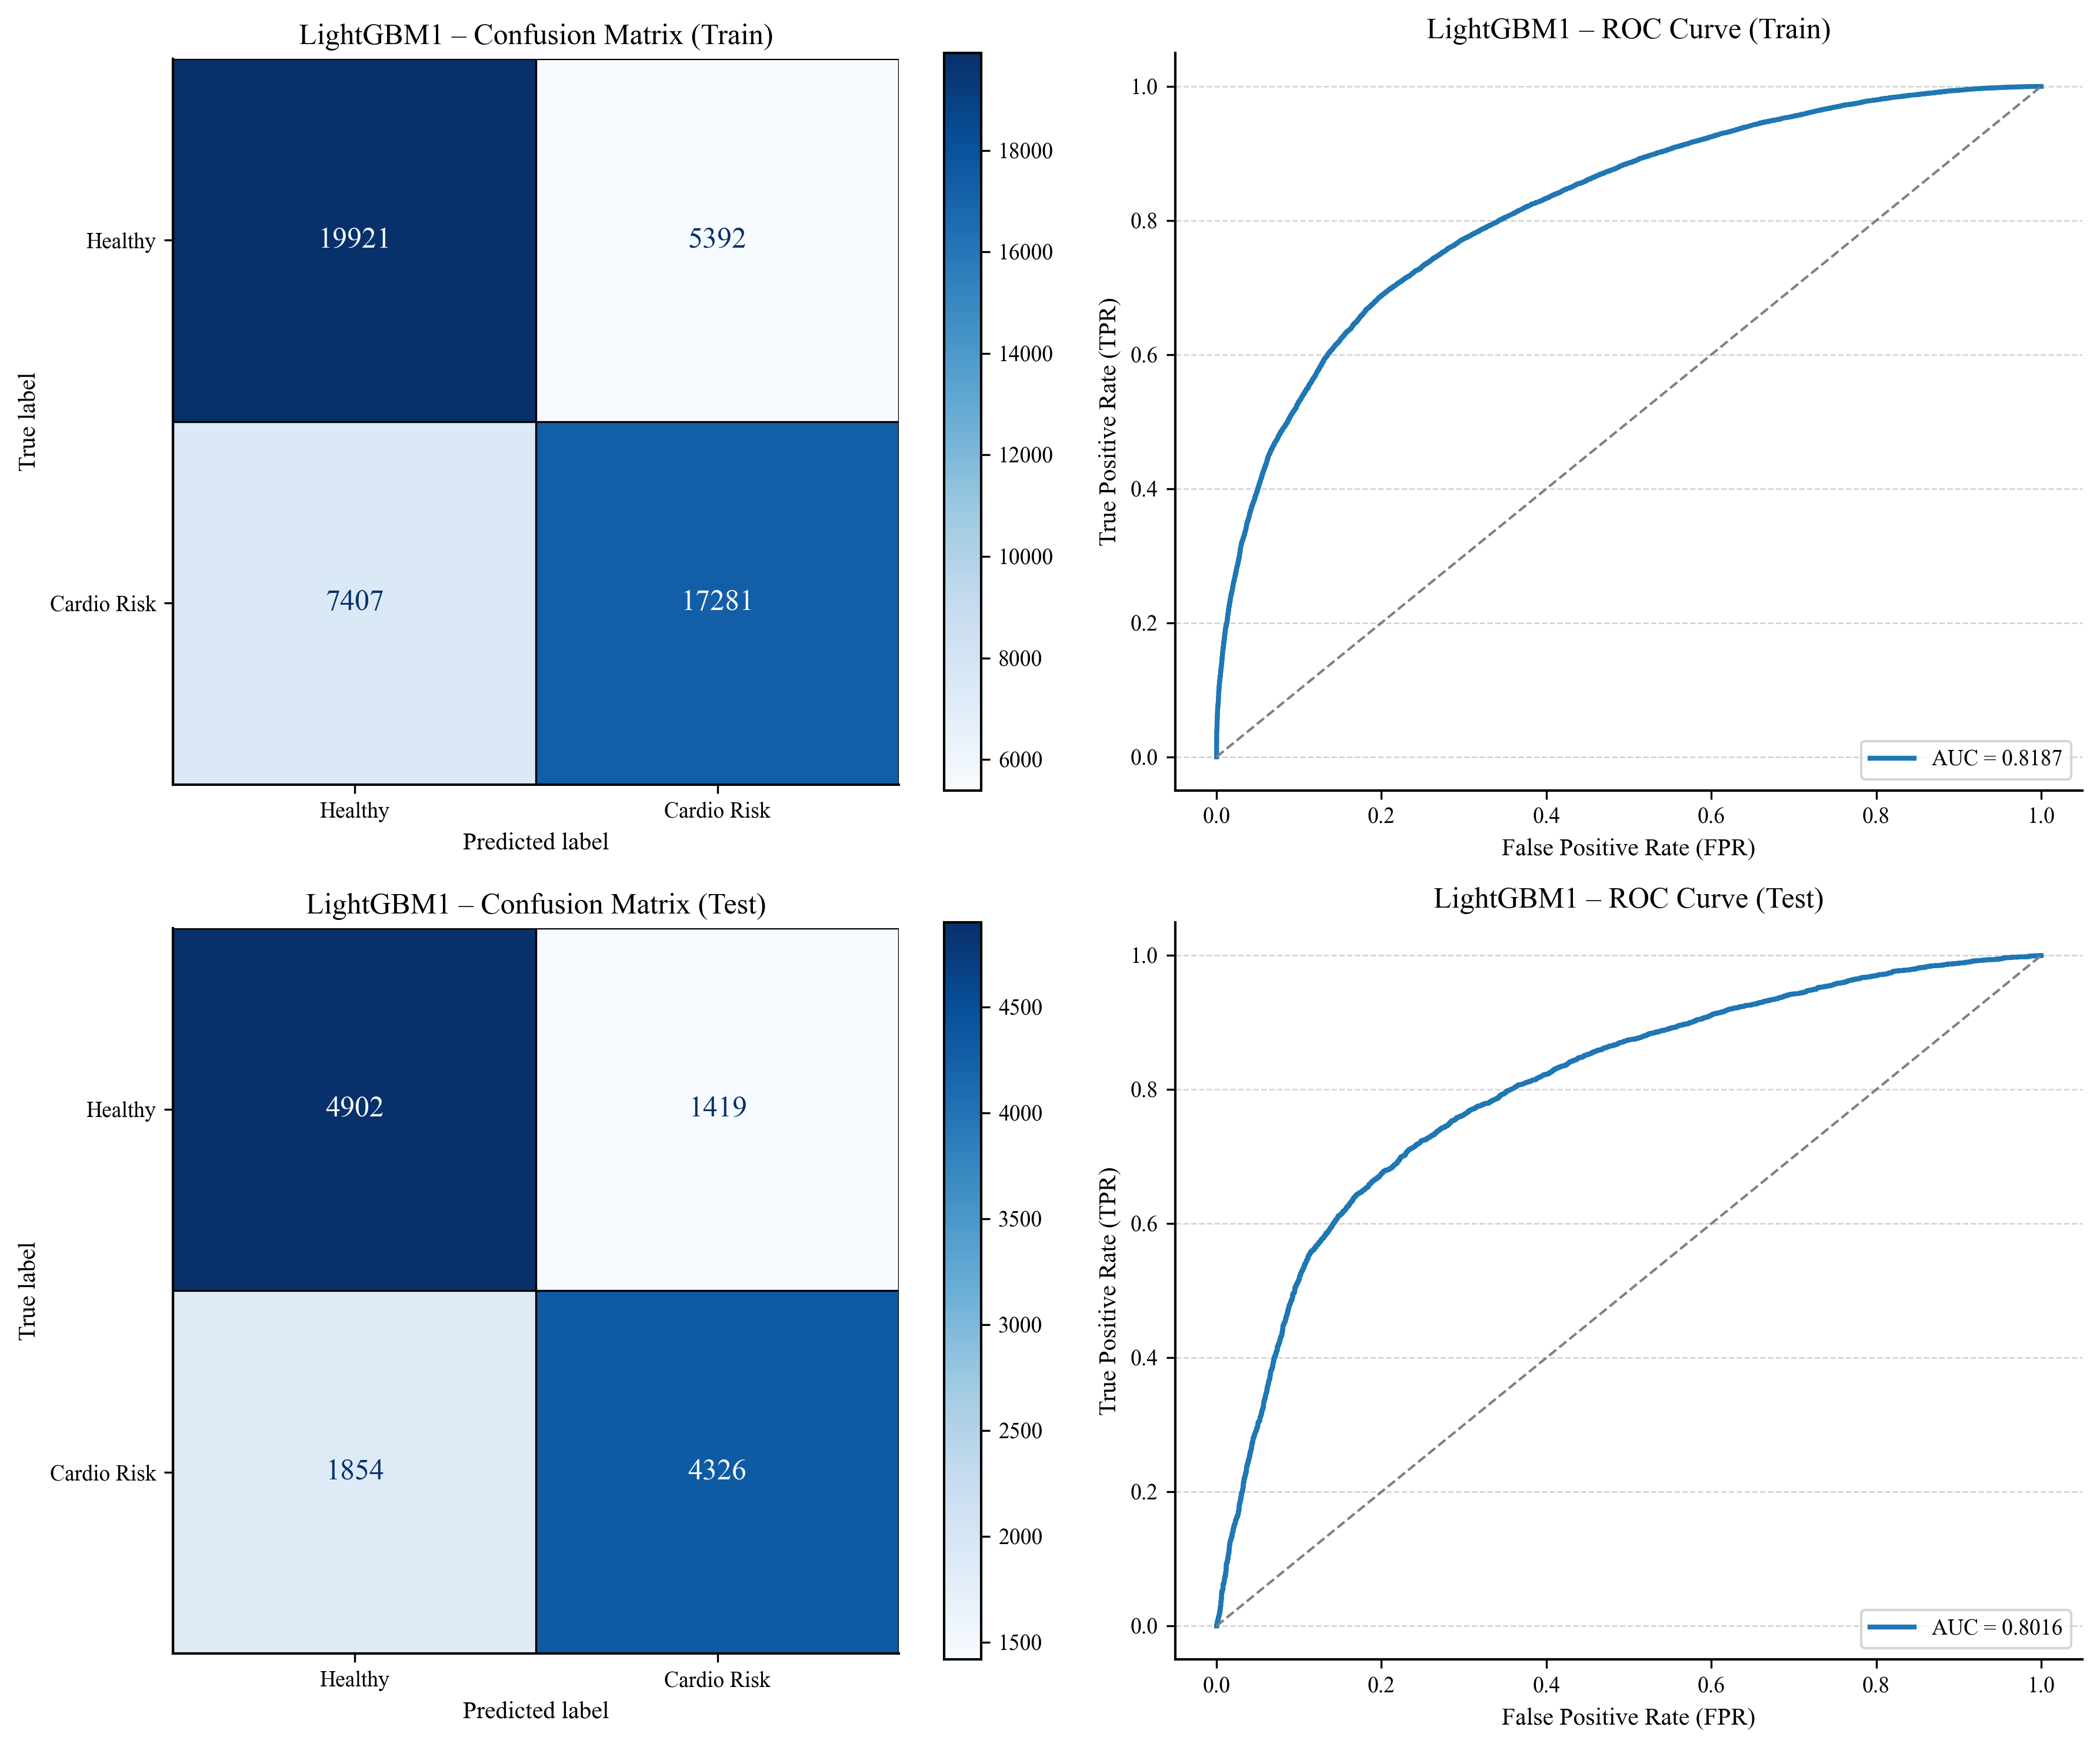

In [6]:
# best_params = {
#     'n_estimators': 233,
#     'learning_rate': 0.019519792757748358,
#     'num_leaves': 41,
#     'max_depth': 15,
#     'subsample': 0.758484089588373,
#     'colsample_bytree': 0.9592852139230149,
#     'random_state': 6580,
#     'verbose' : -1
# }

lgbm_model = LGBMClassifier(verbose=-1)
    
lgbm_model.fit(x_train_np, y_train_np)

lgbm_results = evaluate_model(
    model=lgbm_model,
    model_name="LightGBM1",
    plot_cm_roc=True
)

lgbm_results;



                  === CatBoost Results ===                  
Test Acc: 0.7379, AUC: 0.8013
              precision    recall  f1-score   support

           0     0.7251    0.7760    0.7497      6321
           1     0.7531    0.6990    0.7251      6180

    accuracy                         0.7379     12501
   macro avg     0.7391    0.7375    0.7374     12501
weighted avg     0.7389    0.7379    0.7375     12501

Train Acc: 0.7529, AUC: 0.8309
              precision    recall  f1-score   support

           0     0.7363    0.7975    0.7657     25313
           1     0.7730    0.7071    0.7386     24688

    accuracy                         0.7529     50001
   macro avg     0.7546    0.7523    0.7521     50001
weighted avg     0.7544    0.7529    0.7523     50001

✅ No significant overfitting



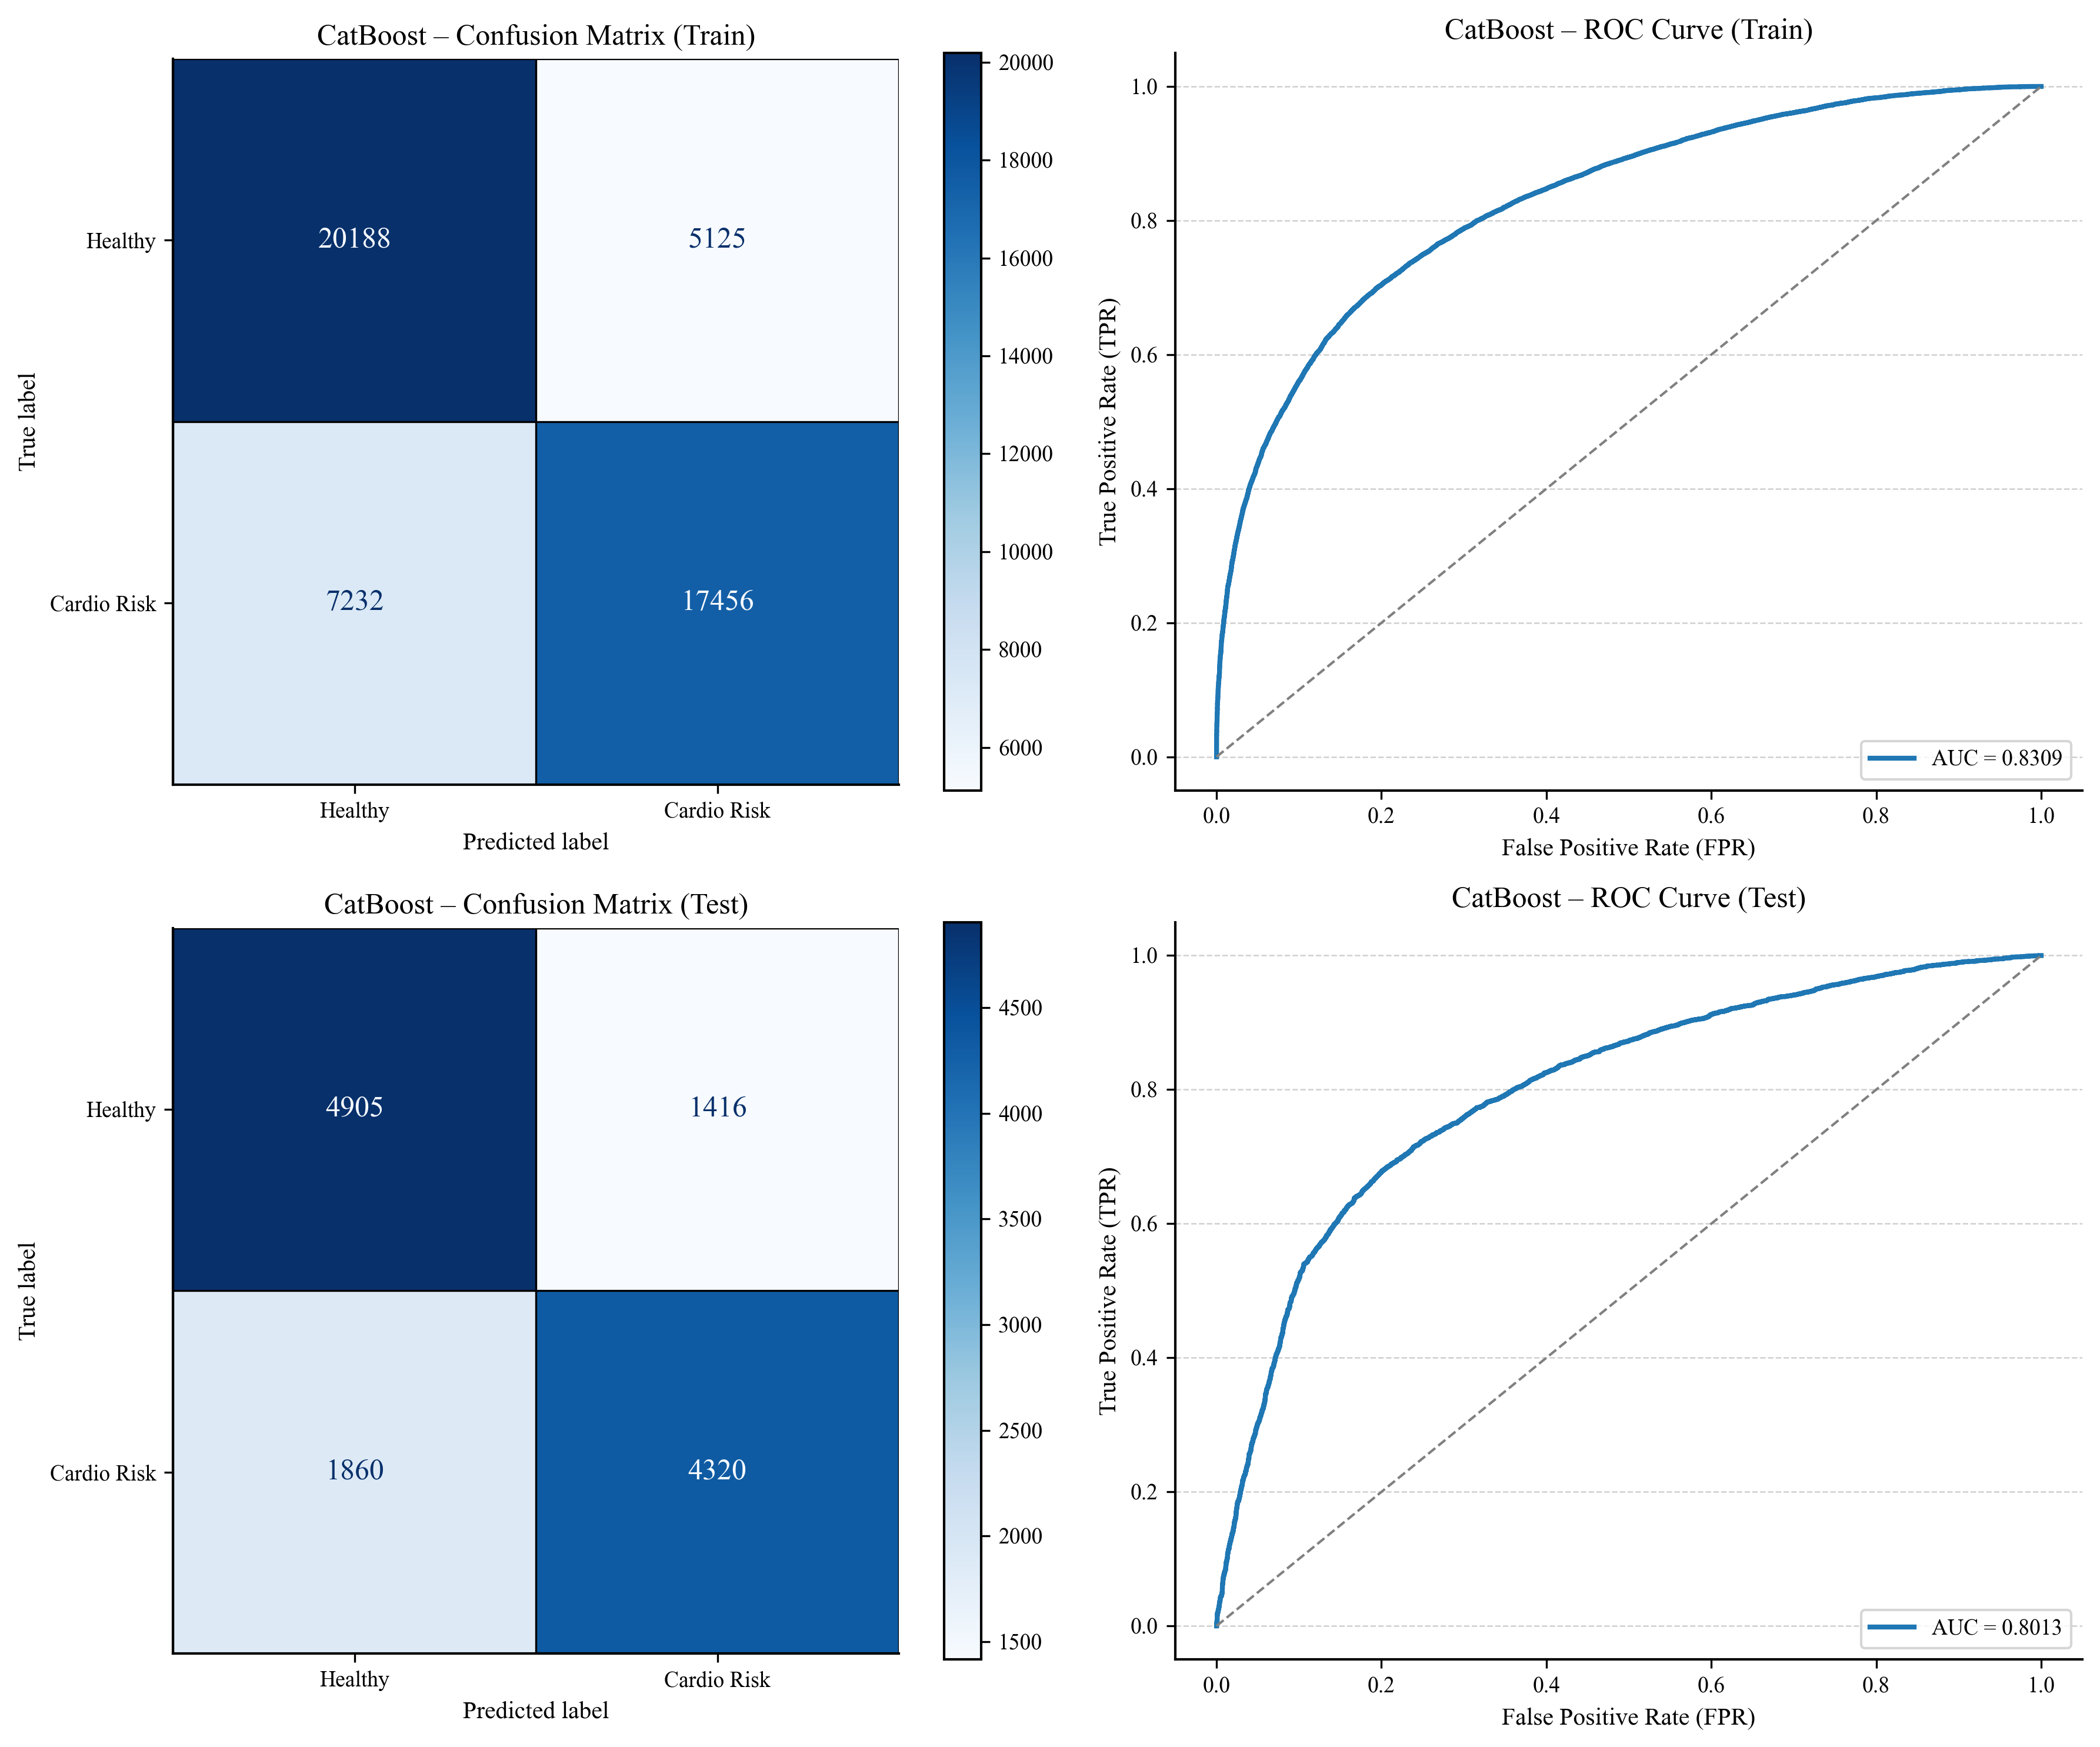

In [7]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)

catb_model.fit(x_train_np, y_train_np)

catb_results = evaluate_model(
    model               = catb_model, 
    model_name          = "CatBoost", 
    plot_cm_roc         = True
)

catb_results;


           === Hist Gradient Boosting Results ===           
Test Acc: 0.7372, AUC: 0.8007
              precision    recall  f1-score   support

           0     0.7262    0.7711    0.7479      6321
           1     0.7500    0.7026    0.7255      6180

    accuracy                         0.7372     12501
   macro avg     0.7381    0.7368    0.7367     12501
weighted avg     0.7380    0.7372    0.7369     12501

Train Acc: 0.7414, AUC: 0.8151
              precision    recall  f1-score   support

           0     0.7281    0.7806    0.7535     25313
           1     0.7571    0.7011    0.7280     24688

    accuracy                         0.7414     50001
   macro avg     0.7426    0.7409    0.7407     50001
weighted avg     0.7424    0.7414    0.7409     50001

✅ No significant overfitting



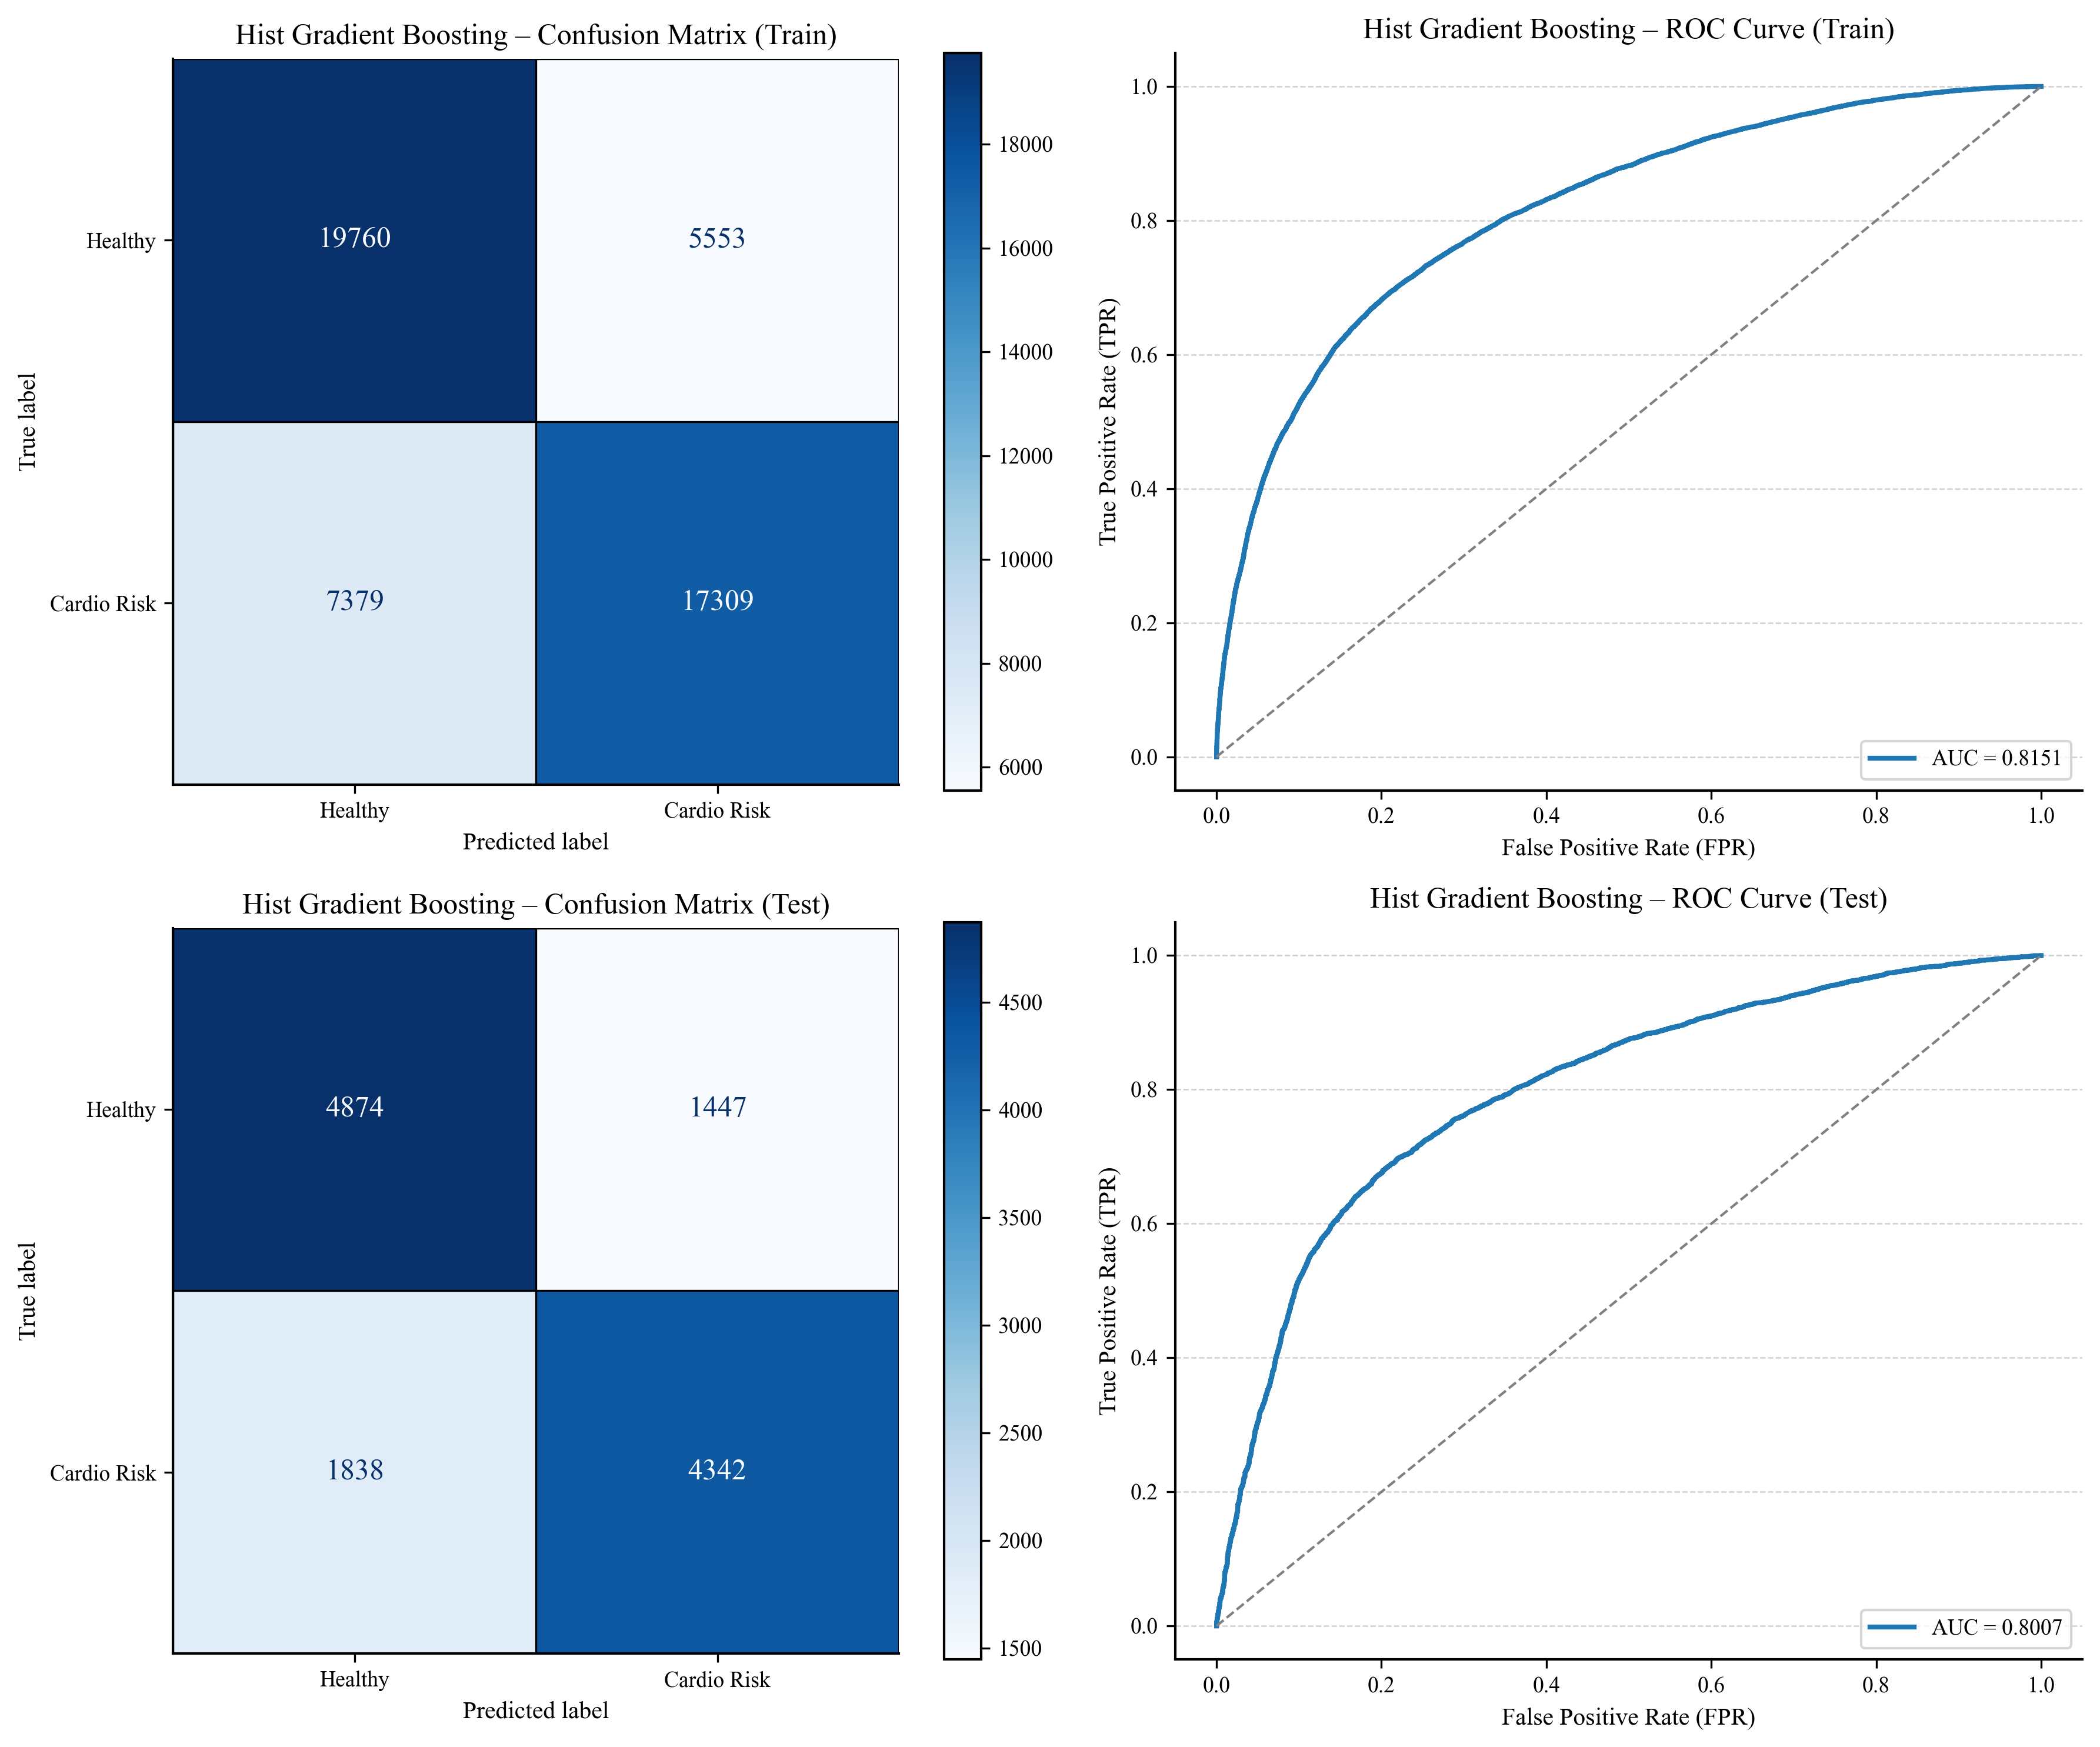

In [8]:

# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)

hgrb_model.fit(x_train_np, y_train_np)

hgrb_results = evaluate_model(
    model               = hgrb_model, 
    model_name          = "Hist Gradient Boosting", 
    plot_cm_roc         = True
)

hgrb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



                  === AdaBoost Results ===                  
Test Acc: 0.7320, AUC: 0.7946
              precision    recall  f1-score   support

           0     0.7048    0.8089    0.7532      6321
           1     0.7697    0.6534    0.7068      6180

    accuracy                         0.7320     12501
   macro avg     0.7372    0.7311    0.7300     12501
weighted avg     0.7369    0.7320    0.7303     12501

Train Acc: 0.7238, AUC: 0.7898
              precision    recall  f1-score   support

           0     0.6968    0.8044    0.7468     25313
           1     0.7618    0.6412    0.6963     24688

    accuracy                         0.7238     50001
   macro avg     0.7293    0.7228    0.7215     50001
weighted avg     0.7289    0.7238    0.7219     50001

✅ No significant overfitting



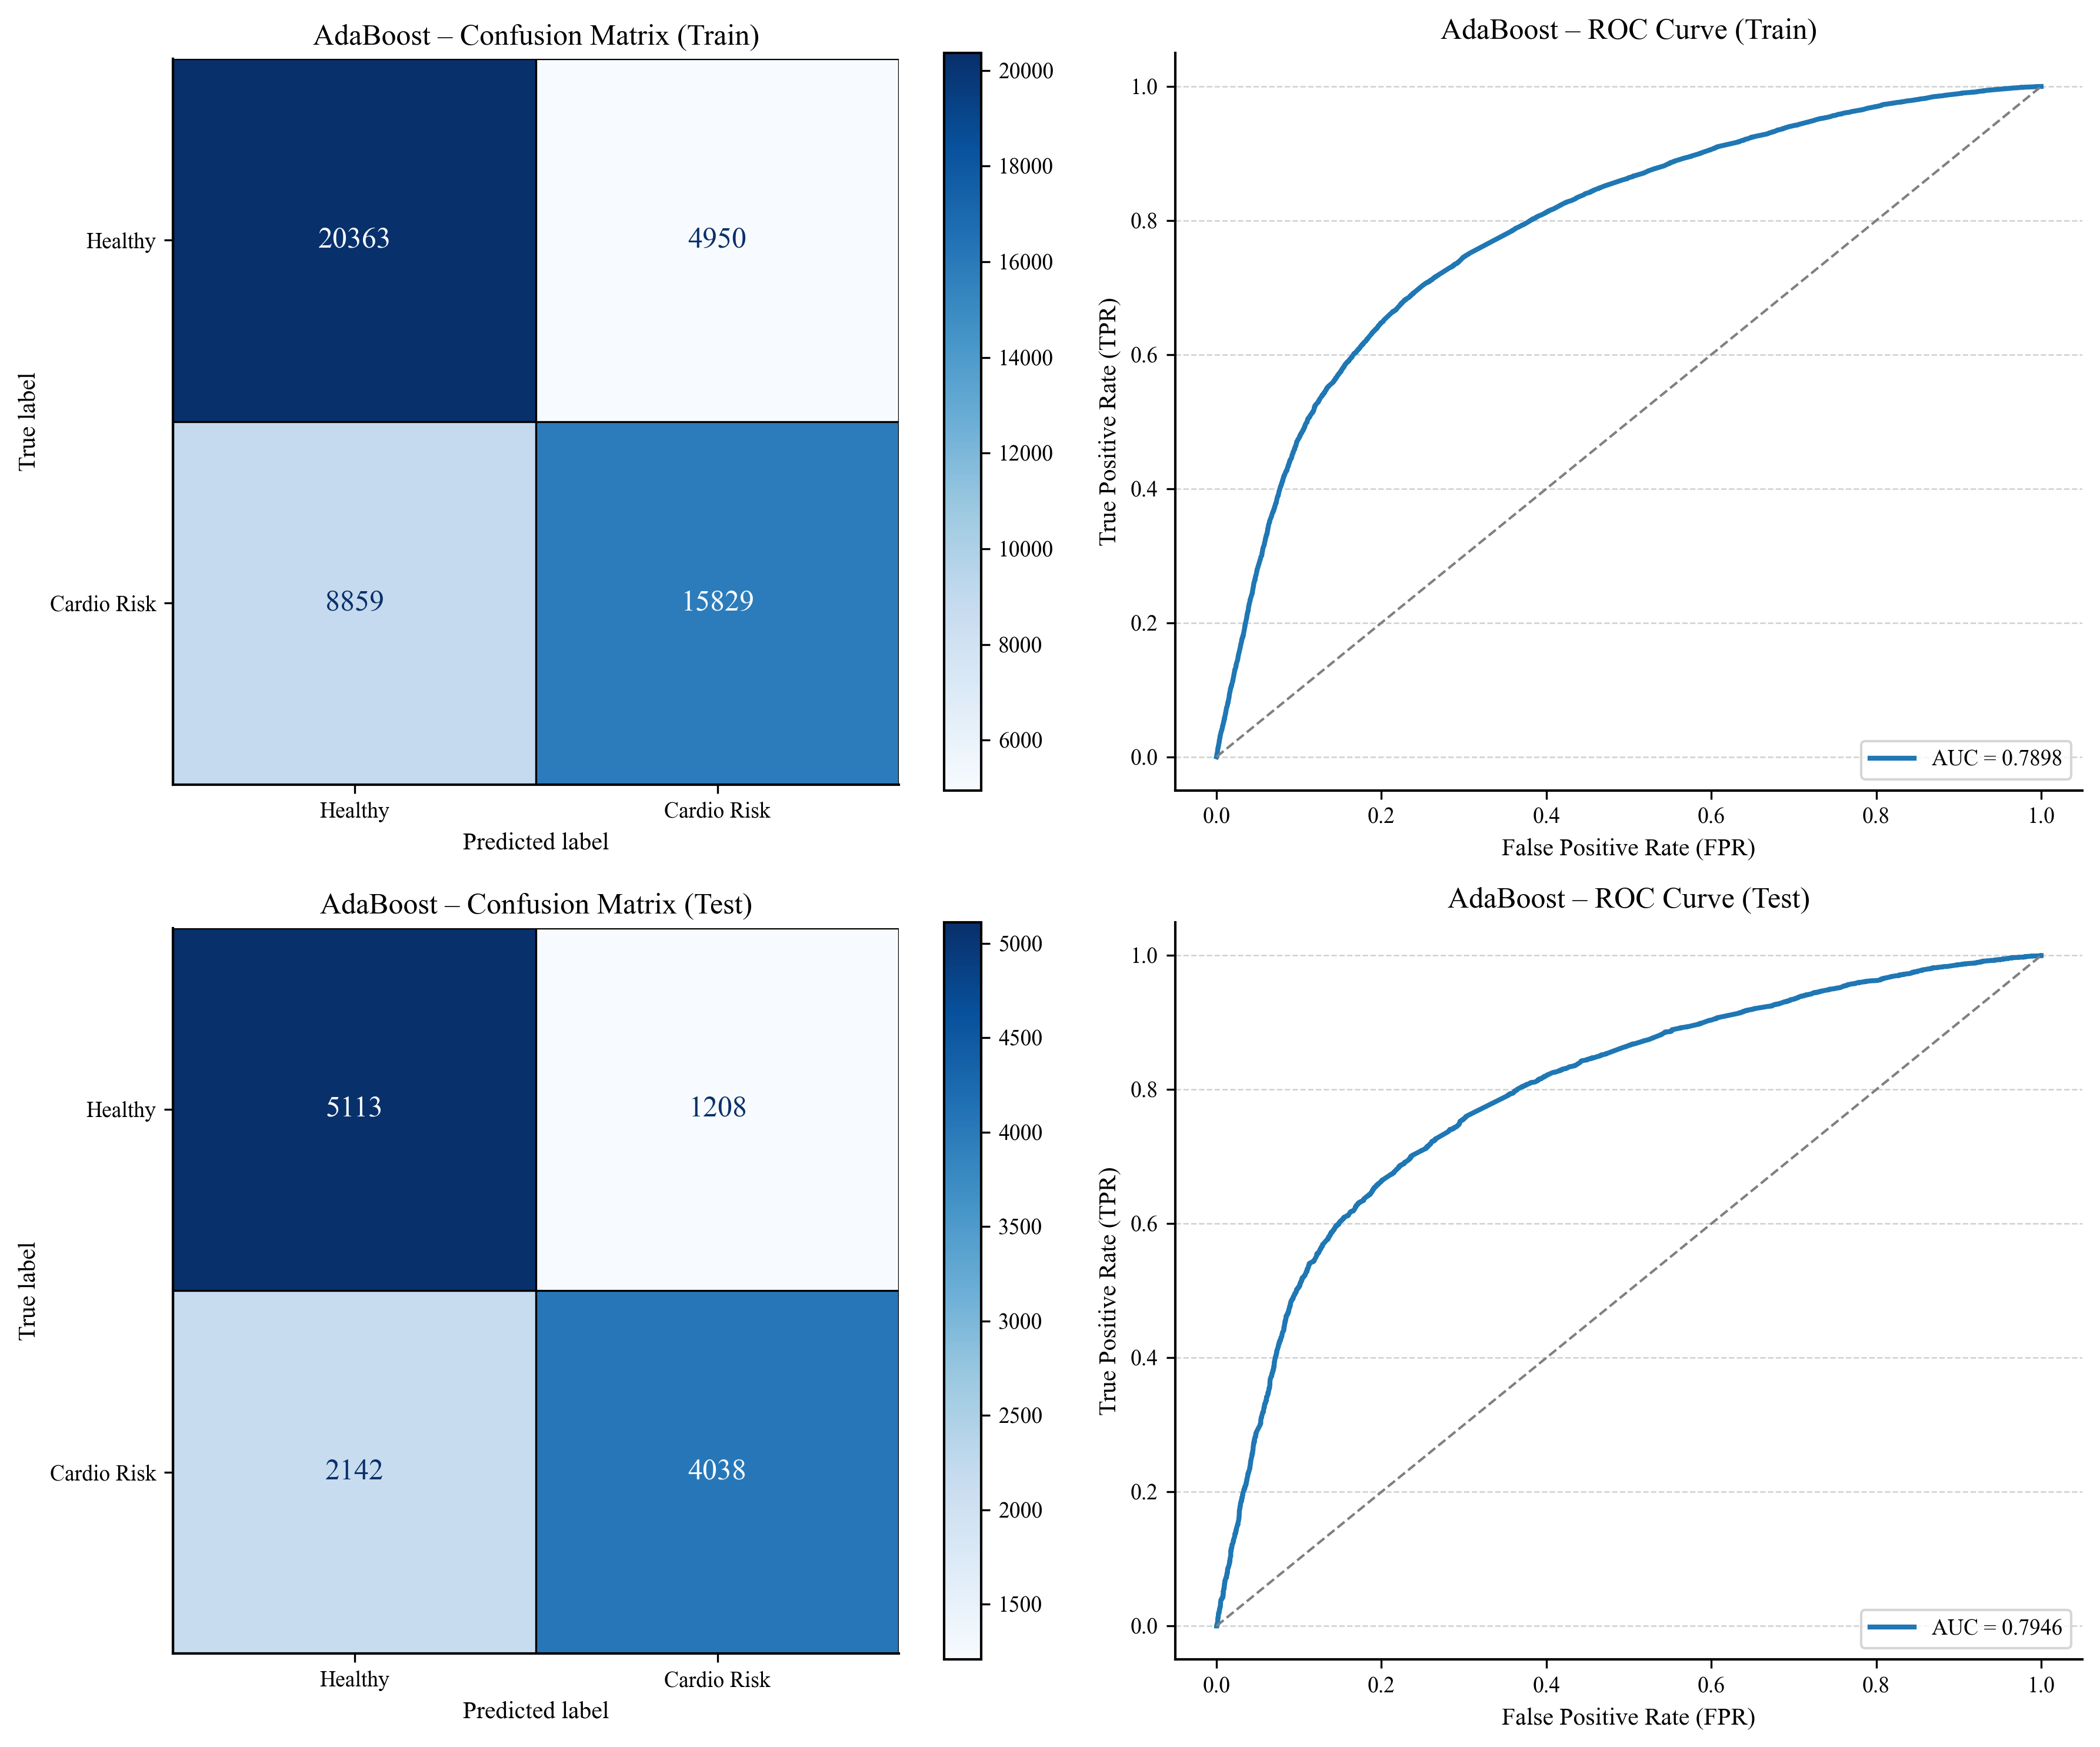

In [9]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_model.fit(x_train_np, y_train_np)

adb_results = evaluate_model(
    model               = adb_model, 
    model_name          = "AdaBoost", 
    plot_cm_roc         = True
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



                   === TabNet Results ===                   
Test Acc: 0.7382, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7237    0.7801    0.7508      6321
           1     0.7556    0.6953    0.7242      6180

    accuracy                         0.7382     12501
   macro avg     0.7396    0.7377    0.7375     12501
weighted avg     0.7394    0.7382    0.7377     12501

Train Acc: 0.7330, AUC: 0.7995
              precision    recall  f1-score   support

           0     0.7176    0.7794    0.7472     25313
           1     0.7519    0.6854    0.7171     24688

    accuracy                         0.7330     50001
   macro avg     0.7347    0.7324    0.7322     50001
weighted avg     0.7345    0.7330    0.7324     50001

✅ No significant overfitting



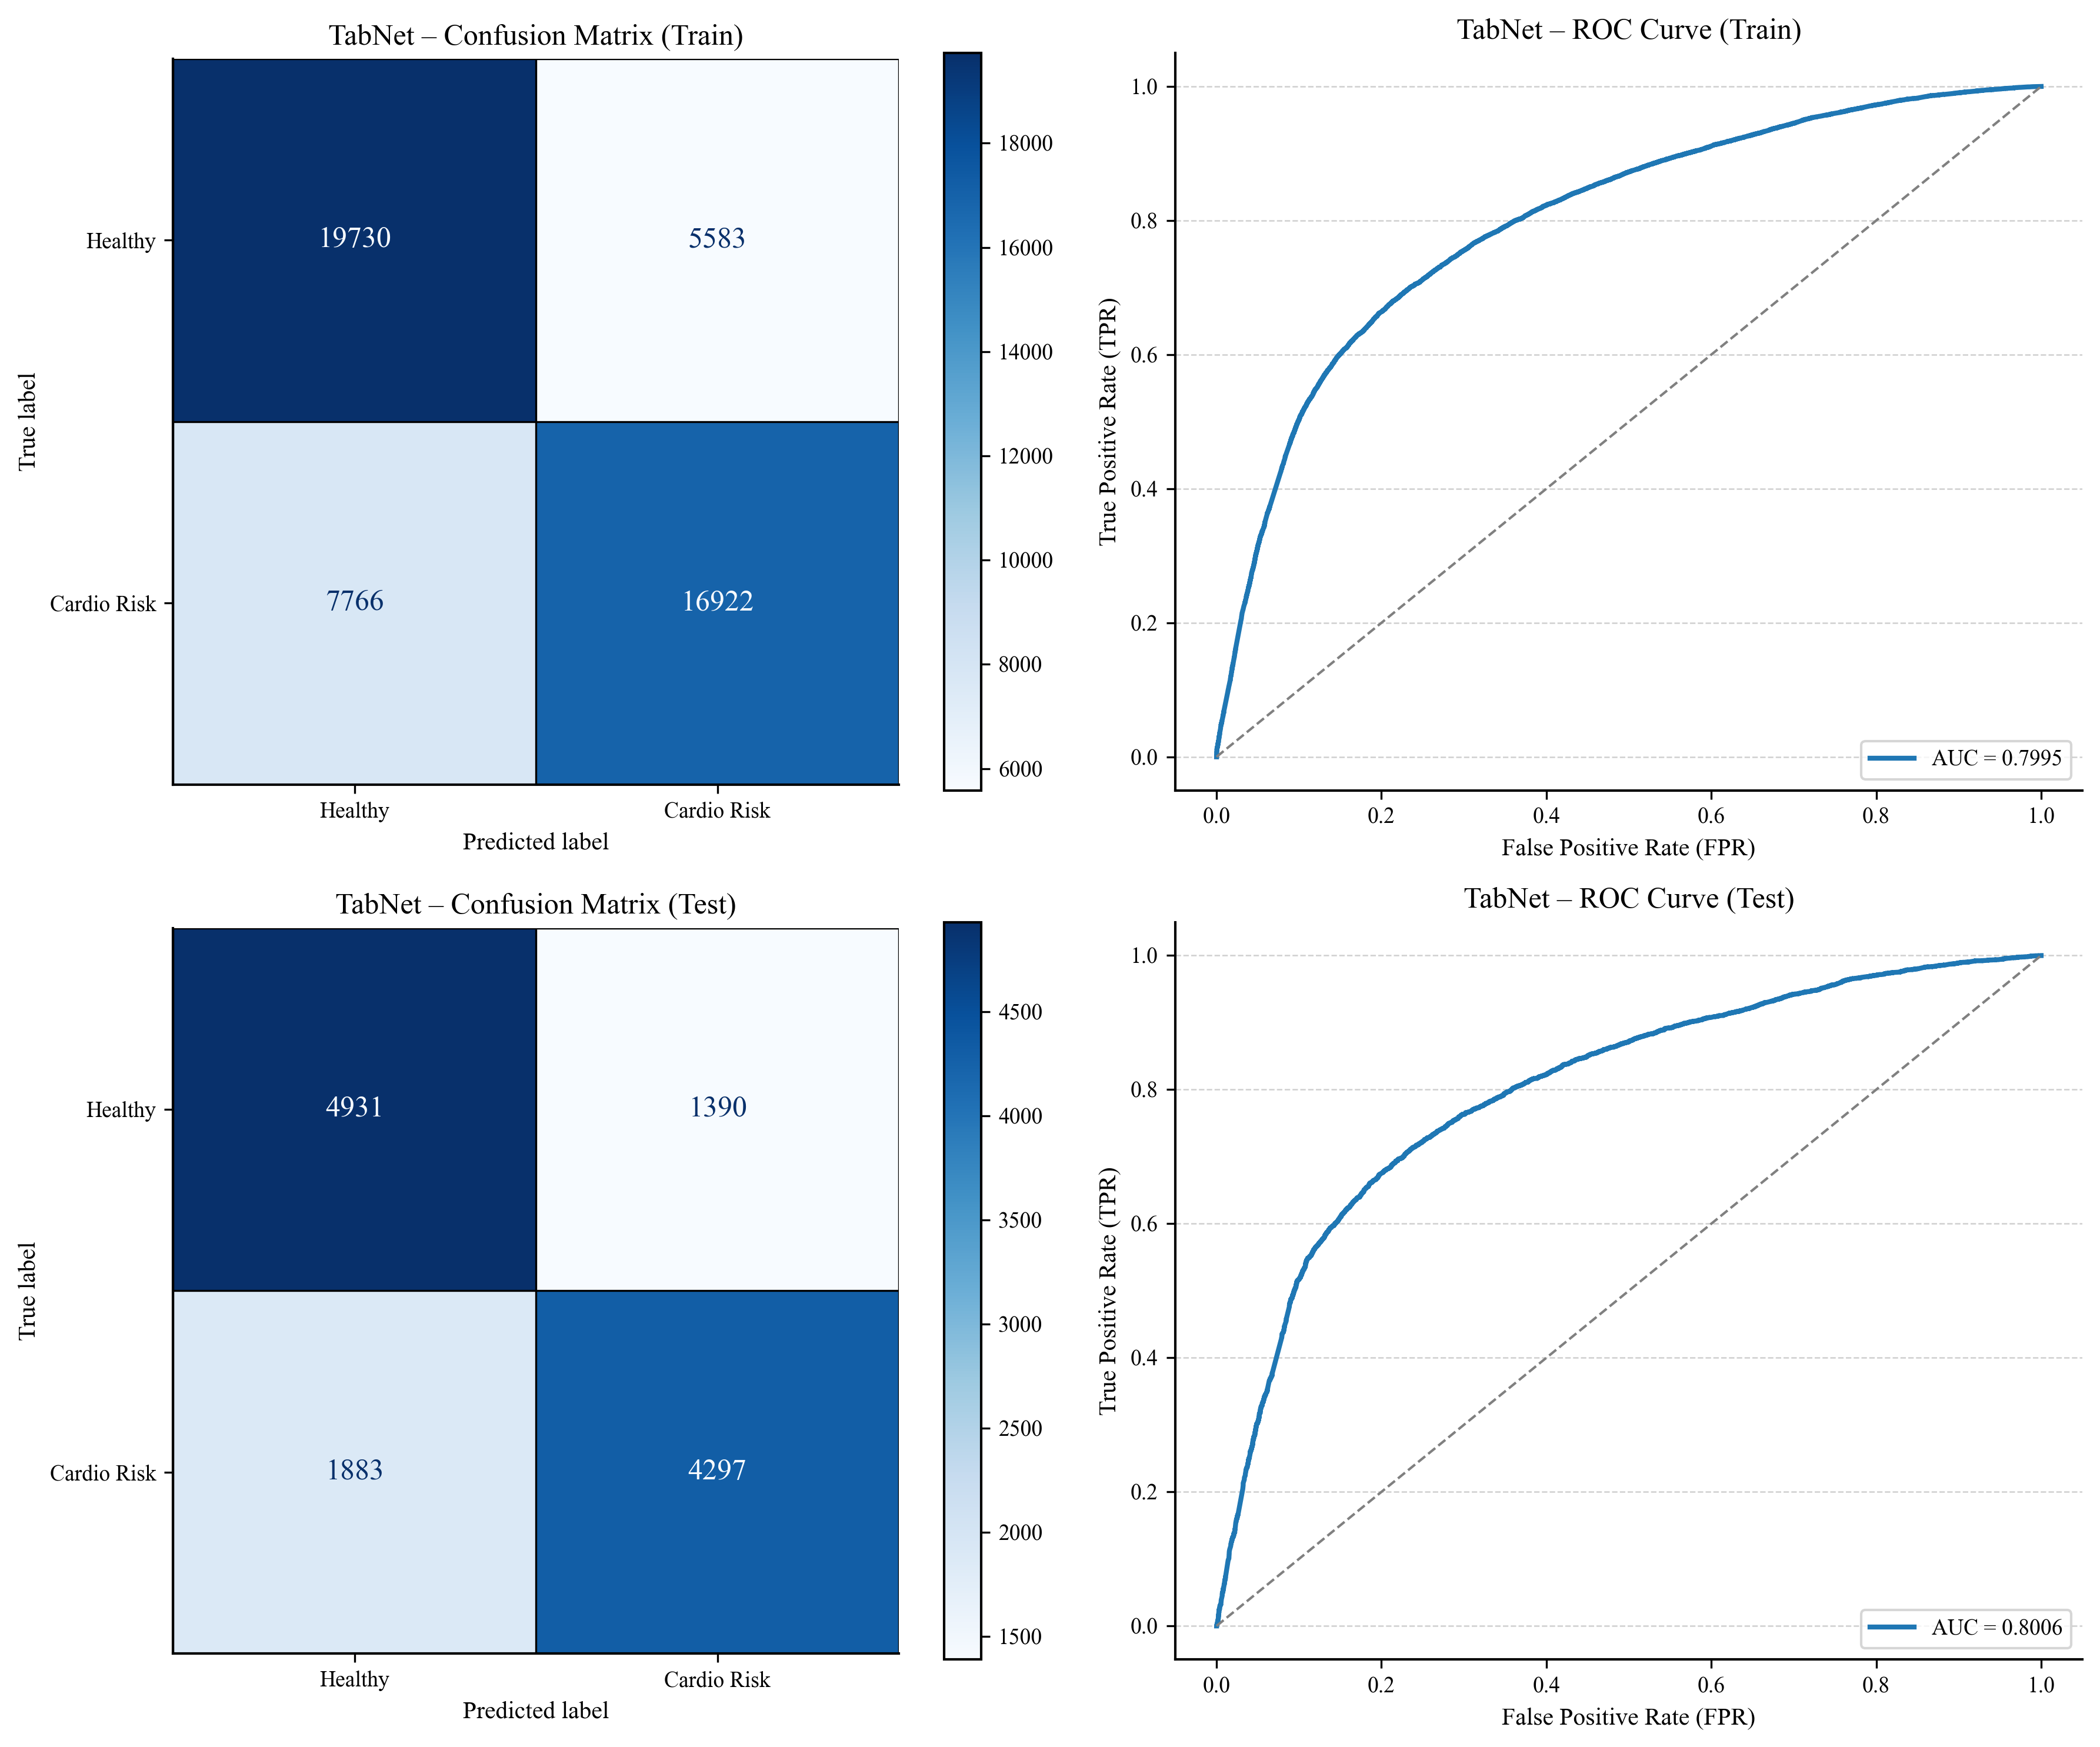

In [10]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_model.fit(x_train_np, y_train_np)

tabnet_results = evaluate_model(
    model               = tabnet_model, 
    model_name          = "TabNet", 
    plot_cm_roc         = True
)

tabnet_results;

In [11]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[Wrapper] Epoch 1/10, Loss: 0.5974
[Wrapper] Epoch 2/10, Loss: 0.5654
[Wrapper] Epoch 3/10, Loss: 0.5637
[Wrapper] Epoch 4/10, Loss: 0.5617
[Wrapper] Epoch 5/10, Loss: 0.5616
[Wrapper] Epoch 6/10, Loss: 0.5601
[Wrapper] Epoch 7/10, Loss: 0.5590
[Wrapper] Epoch 8/10, Loss: 0.5589
[Wrapper] Epoch 9/10, Loss: 0.5575
[Wrapper] Epoch 10/10, Loss: 0.5582

               === TabTransformer Results ===               
Test Acc: 0.7347, AUC: 0.7965
              precision    recall  f1-score   support

           0     0.7046    0.8184    0.7572      6321
           1     0.7775    0.6490    0.7075      6180

    accuracy                         0.7347     12501
   macro avg     0.7410    0.7337    0.7323     12501
weighted avg     0.7406    0.7347    0.7326     12501

Train Acc: 0.7253, AUC: 0.7919
              precision    recall  f1-score   support

           0     0.6960    0.8122    0.7496     25313
           1     0.7676    0.6363    0.6958     24688

    accuracy                       

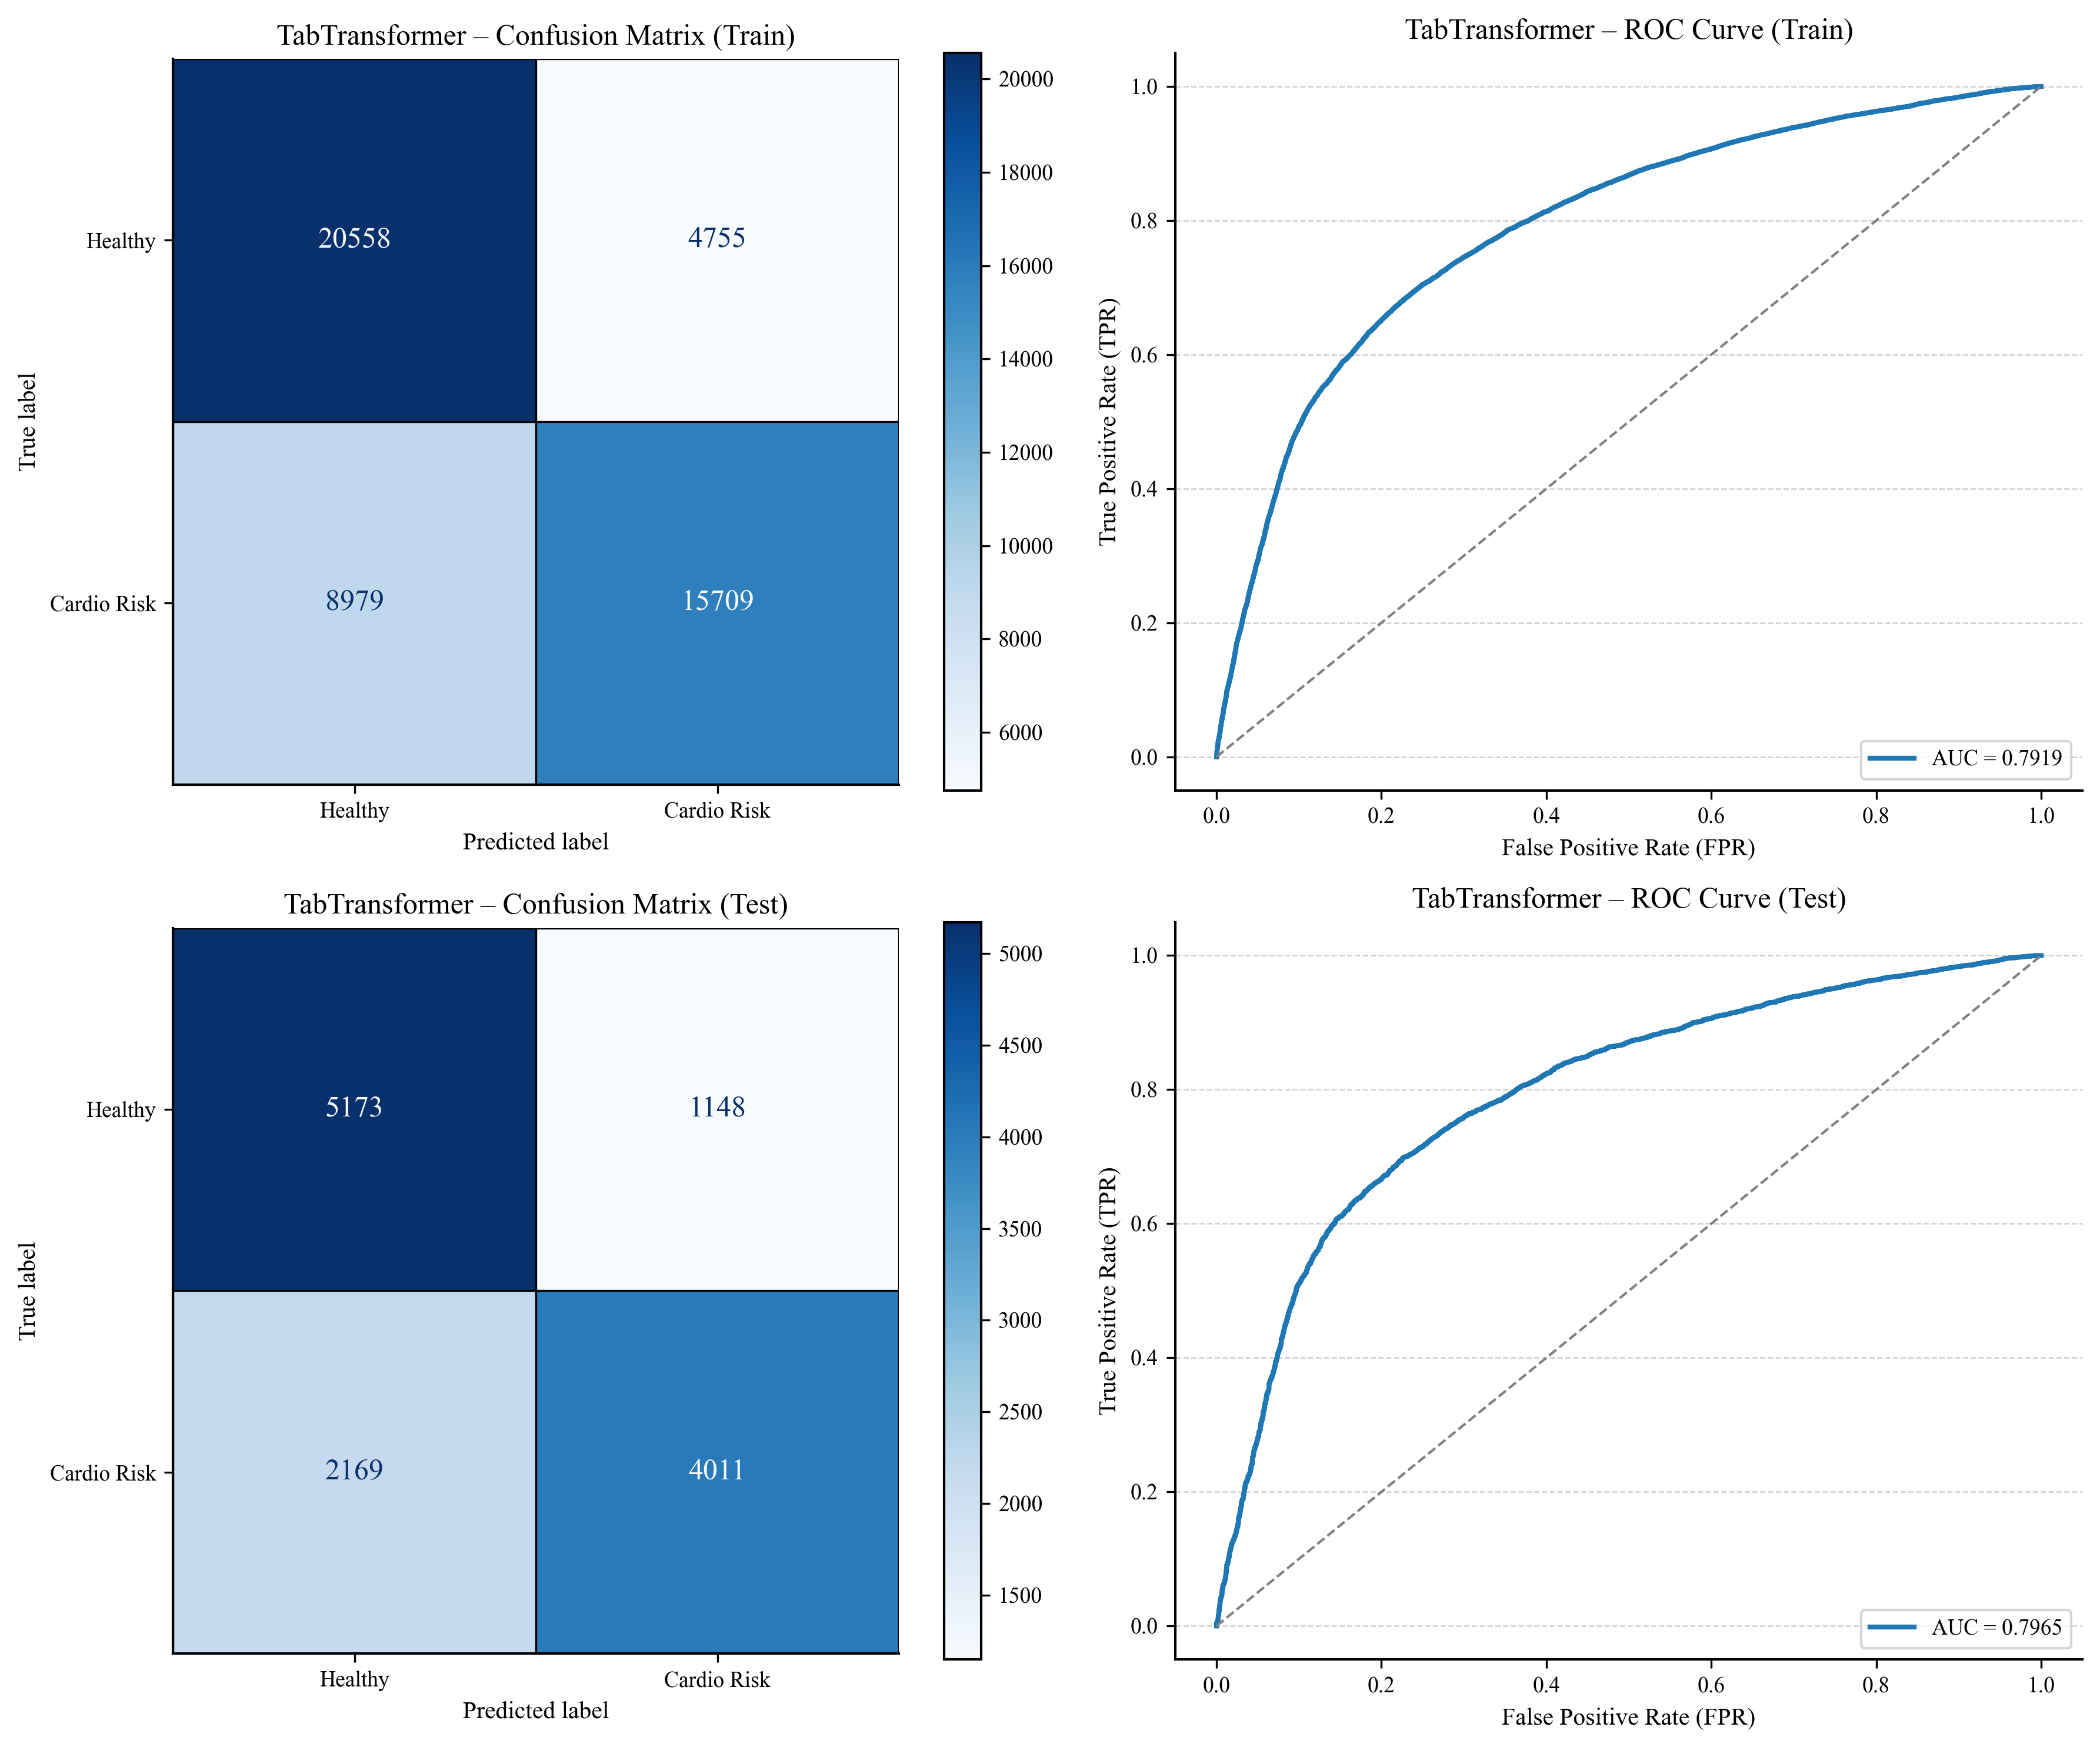

In [12]:
tabtf_model = TabTransformer(
    categories            = (3, 3, 2, 2, 2, 2), 
    num_continuous        = len(continuous_indices),
    dim                   = 32,
    dim_out               = 1,
    depth                 = 6,
    heads                 = 8,
    attn_dropout          = 0.1,
    ff_dropout            = 0.1,
    mlp_hidden_mults      = (4, 2),
    mlp_act               = nn.ReLU(),
    continuous_mean_std   = None
).to(device)


tabtf_wrapper = PyTorchClassifier(
    model                 = tabtf_model,
    epochs                = 10,
    batch_size            = 32,
    lr                    = 1e-3,
    categorical_indices = categorical_indices,
    continuous_indices  = continuous_indices,
)

tabtf_wrapper.fit(x_train_np, y_train_np)

tabtf_results = evaluate_model(
    model               = tabtf_wrapper,
    model_name          = "TabTransformer",
    plot_cm_roc         = True
    )

tabtf_results;

[Wrapper] Epoch 1/10, Loss: 0.5599
[Wrapper] Epoch 2/10, Loss: 0.5527
[Wrapper] Epoch 3/10, Loss: 0.5519
[Wrapper] Epoch 4/10, Loss: 0.5512
[Wrapper] Epoch 5/10, Loss: 0.5500
[Wrapper] Epoch 6/10, Loss: 0.5503
[Wrapper] Epoch 7/10, Loss: 0.5498
[Wrapper] Epoch 8/10, Loss: 0.5494
[Wrapper] Epoch 9/10, Loss: 0.5487
[Wrapper] Epoch 10/10, Loss: 0.5490

               === FT-Transformer Results ===               
Test Acc: 0.7395, AUC: 0.8019
              precision    recall  f1-score   support

           0     0.7185    0.7970    0.7557      6321
           1     0.7663    0.6806    0.7209      6180

    accuracy                         0.7395     12501
   macro avg     0.7424    0.7388    0.7383     12501
weighted avg     0.7421    0.7395    0.7385     12501

Train Acc: 0.7314, AUC: 0.7977
              precision    recall  f1-score   support

           0     0.7095    0.7948    0.7498     25313
           1     0.7601    0.6664    0.7101     24688

    accuracy                       

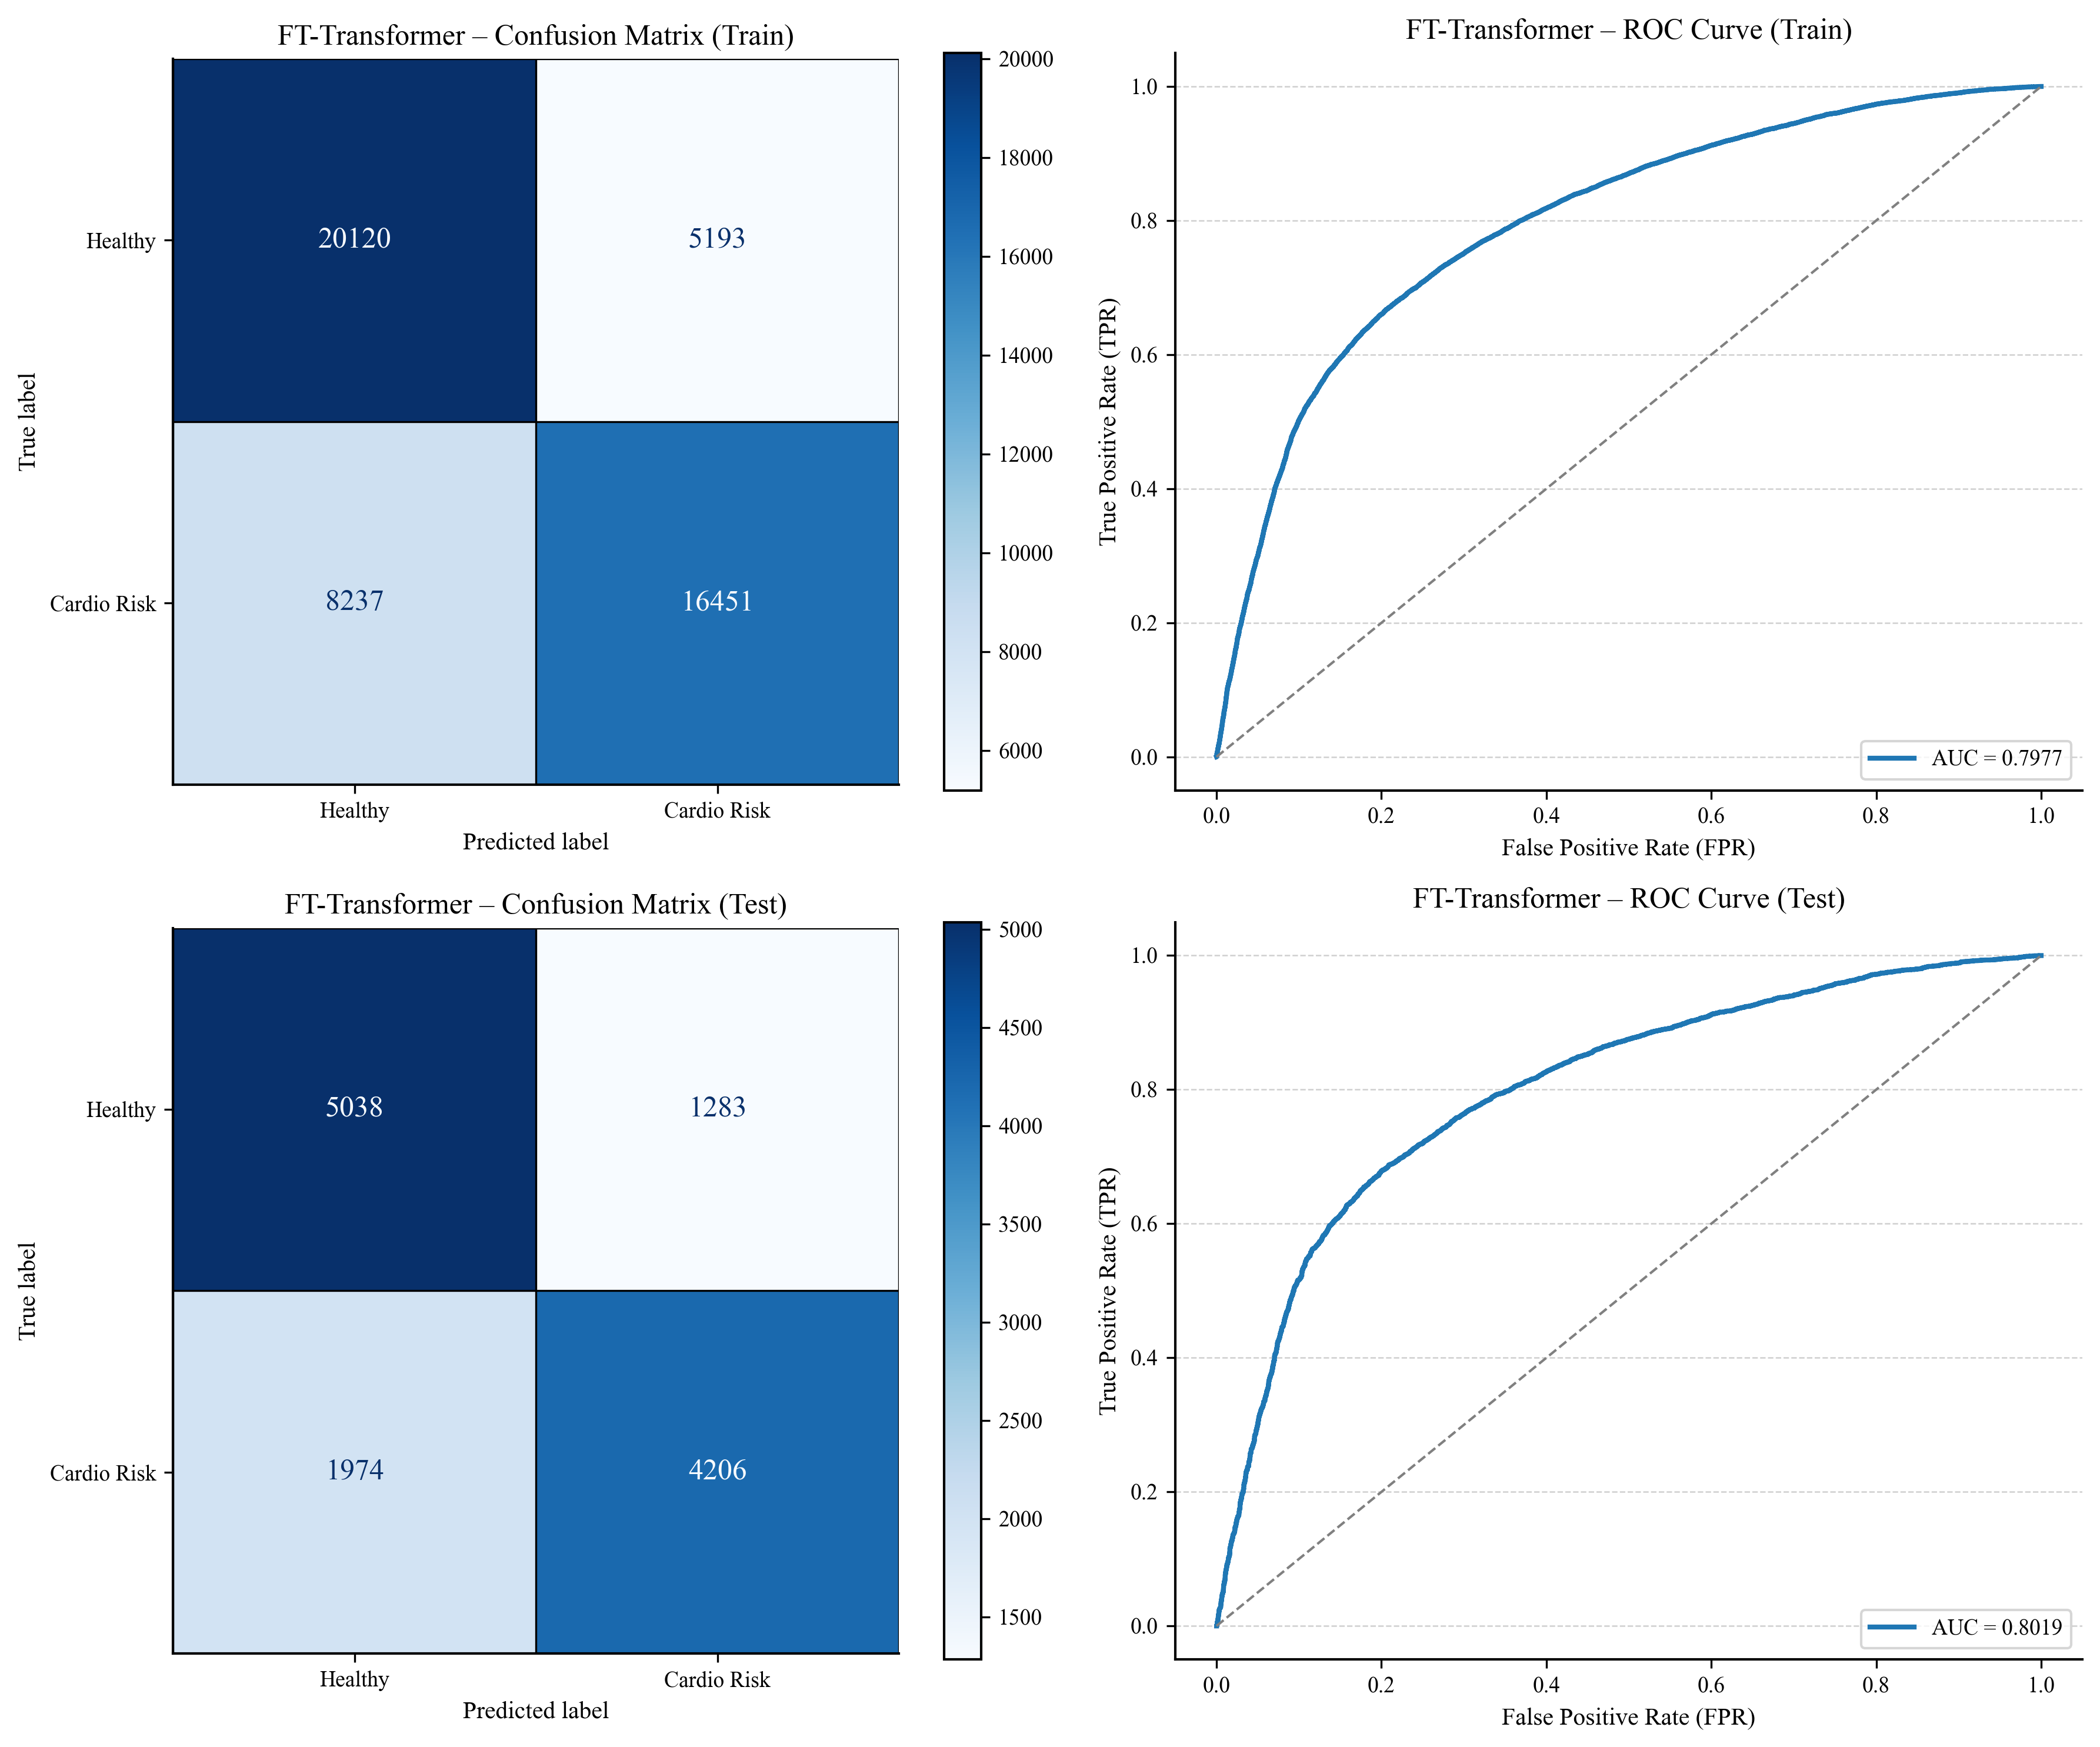

In [13]:
fttf_model = FTTransformer(
    categories          = (3, 3, 2, 2, 2, 2), 
    num_continuous      = len(continuous_indices),
    dim                 = 32,
    dim_out             = 1,
    depth               = 6,
    heads               = 8,
    attn_dropout        = 0.1,
    ff_dropout          = 0.1
).to(device)

fttf_wrapper = PyTorchClassifier(
    model               = fttf_model,
    epochs              = 10,
    batch_size          = 32,
    lr                  = 1e-3,
    categorical_indices = categorical_indices,
    continuous_indices  = continuous_indices,
)

fttf_wrapper.fit(x_train_np, y_train_np)

fttf_results = evaluate_model(
    model               = fttf_wrapper,
    model_name          = "FT-Transformer",
    plot_cm_roc         = True
    )

fttf_results;

In [14]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

base_models_hybird = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf',tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

In [15]:
meta_model = adb_model

In [16]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_hybird = StackingClassifier(estimators=base_models_hybird,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [17]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7538c236f9d0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


             === Stacking ML Model Results ===              
Test Acc: 0.7385, AUC: 0.7999
              precision    recall  f1-score   support

           0     0.7138    0.8060    0.7571      6321
           1     0.7714    0.6694    0.7168      6180

    accuracy                         0.7385     12501
   macro avg     0.7426    0.7377    0.7370     12501
weighted avg     0.7423    0.7385    0.7372     12501

Train Acc: 0.7487, AUC: 0.8163
              precision    recall  f1-score   support

           0     0.7207    0.8223    0.7682     25313
           1     0.7871    0.6732    0.7257     24688

    accuracy                         0.7487     50001
   macro avg     0.7539    0.7478    0.7469     50001
weighted avg     0.7535    0.7487    0.7472     50001

✅ No significant overfitting



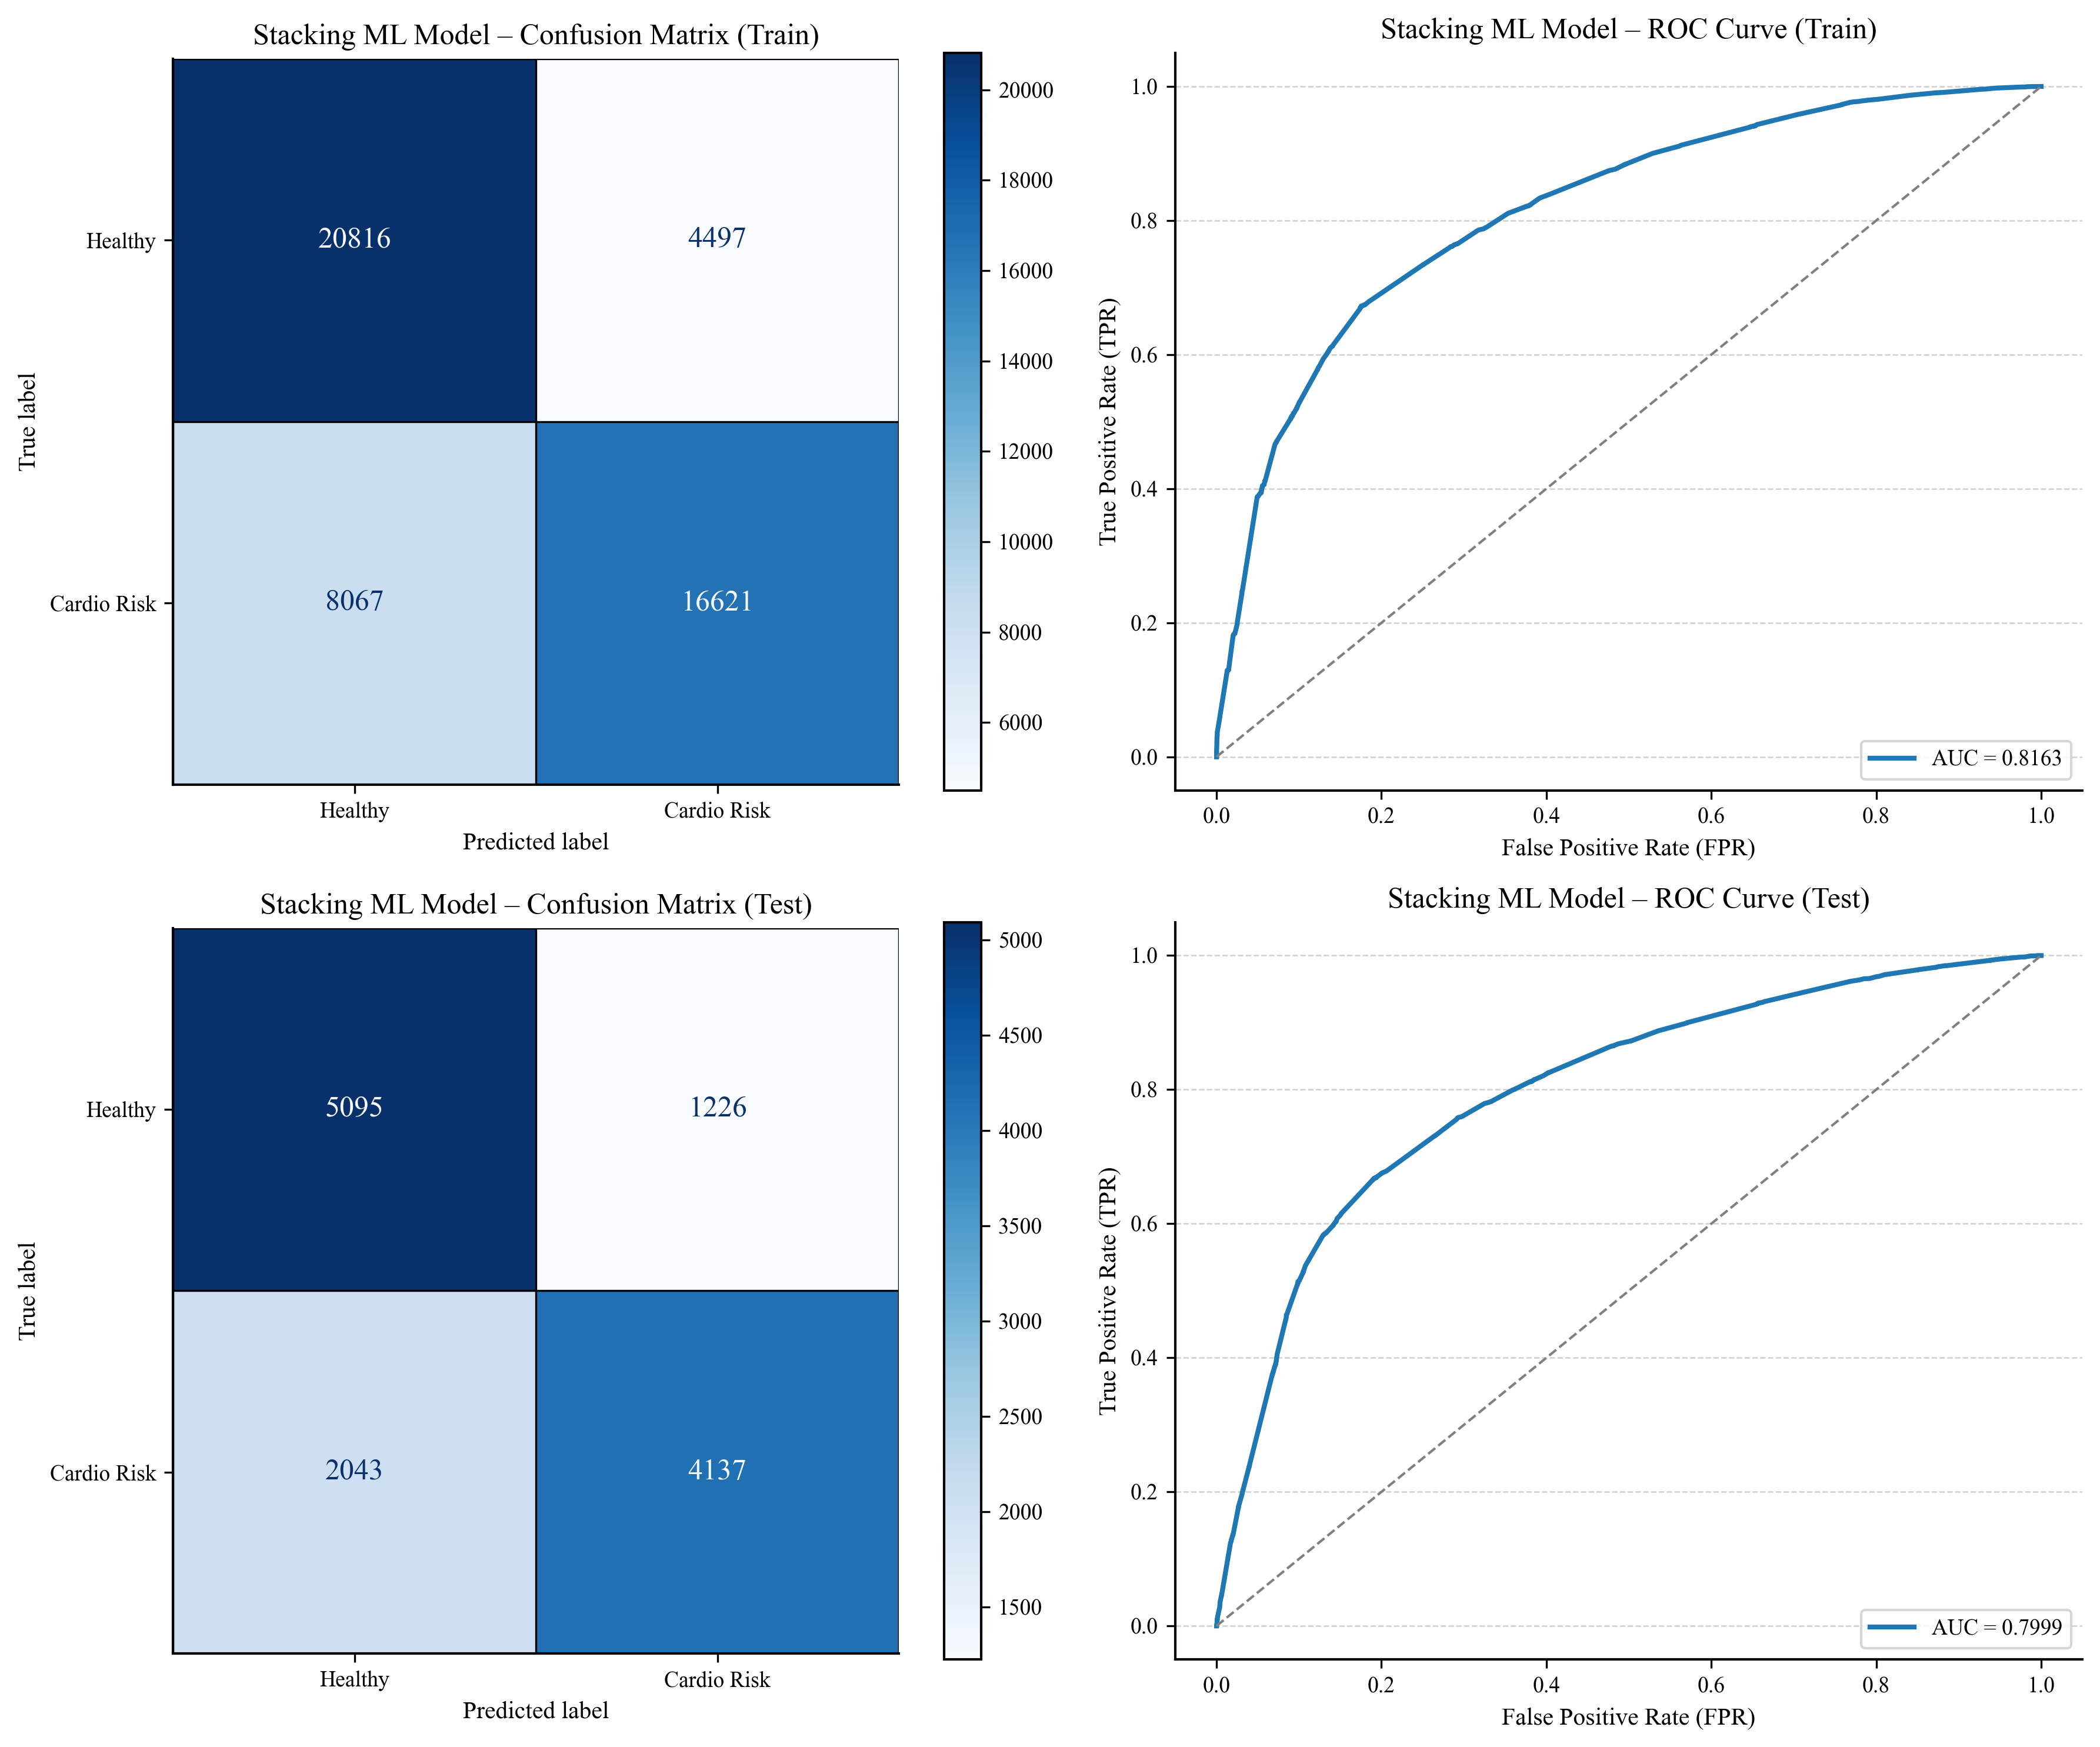

In [18]:
stacking_model_ml_results = evaluate_model(
    model               = stacking_model_ml,
    model_name          = "Stacking ML Model",
    plot_cm_roc         = True
    )

stacking_model_ml_results;

In [19]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5569
[Wrapper] Epoch 2/10, Loss: 0.5558
[Wrapper] Epoch 3/10, Loss: 0.5551
[Wrapper] Epoch 4/10, Loss: 0.5542
[Wrapper] Epoch 5/10, Loss: 0.5540
[Wrapper] Epoch 6/10, Loss: 0.5542
[Wrapper] Epoch 7/10, Loss: 0.5529
[Wrapper] Epoch 8/10, Loss: 0.5529
[Wrapper] Epoch 9/10, Loss: 0.5518
[Wrapper] Epoch 10/10, Loss: 0.5517
[Wrapper] Epoch 1/10, Loss: 0.5482
[Wrapper] Epoch 2/10, Loss: 0.5490
[Wrapper] Epoch 3/10, Loss: 0.5485
[Wrapper] Epoch 4/10, Loss: 0.5483
[Wrapper] Epoch 5/10, Loss: 0.5481
[Wrapper] Epoch 6/10, Loss: 0.5473
[Wrapper] Epoch 7/10, Loss: 0.5468
[Wrapper] Epoch 8/10, Loss: 0.5468
[Wrapper] Epoch 9/10, Loss: 0.5469
[Wrapper] Epoch 10/10, Loss: 0.5471


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5555
[Wrapper] Epoch 2/10, Loss: 0.5549
[Wrapper] Epoch 3/10, Loss: 0.5540
[Wrapper] Epoch 4/10, Loss: 0.5546
[Wrapper] Epoch 5/10, Loss: 0.5540
[Wrapper] Epoch 6/10, Loss: 0.5514
[Wrapper] Epoch 7/10, Loss: 0.5517
[Wrapper] Epoch 8/10, Loss: 0.5517
[Wrapper] Epoch 9/10, Loss: 0.5516
[Wrapper] Epoch 10/10, Loss: 0.5499
[Wrapper] Epoch 1/10, Loss: 0.5557
[Wrapper] Epoch 2/10, Loss: 0.5540
[Wrapper] Epoch 3/10, Loss: 0.5534
[Wrapper] Epoch 4/10, Loss: 0.5530
[Wrapper] Epoch 5/10, Loss: 0.5522
[Wrapper] Epoch 6/10, Loss: 0.5519
[Wrapper] Epoch 7/10, Loss: 0.5514
[Wrapper] Epoch 8/10, Loss: 0.5506
[Wrapper] Epoch 9/10, Loss: 0.5501
[Wrapper] Epoch 10/10, Loss: 0.5489
[Wrapper] Epoch 1/10, Loss: 0.5585
[Wrapper] Epoch 2/10, Loss: 0.5578
[Wrapper] Epoch 3/10, Loss: 0.5559
[Wrapper] Epoch 4/10, Loss: 0.5554
[Wrapper] Epoch 5/10, Loss: 0.5549
[Wrapper] Epoch 6/10, Loss: 0.5551
[Wrapper] Epoch 7/10, Loss: 0.5538
[Wrapper] Epoch 8/10, Loss: 0.5537
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


             === Stacking DL Model Results ===              
Test Acc: 0.7365, AUC: 0.8015
              precision    recall  f1-score   support

           0     0.7175    0.7899    0.7520      6321
           1     0.7604    0.6819    0.7190      6180

    accuracy                         0.7365     12501
   macro avg     0.7389    0.7359    0.7355     12501
weighted avg     0.7387    0.7365    0.7357     12501

Train Acc: 0.7330, AUC: 0.7993
              precision    recall  f1-score   support

           0     0.7126    0.7923    0.7503     25313
           1     0.7594    0.6723    0.7132     24688

    accuracy                         0.7330     50001
   macro avg     0.7360    0.7323    0.7318     50001
weighted avg     0.7357    0.7330    0.7320     50001

✅ No significant overfitting



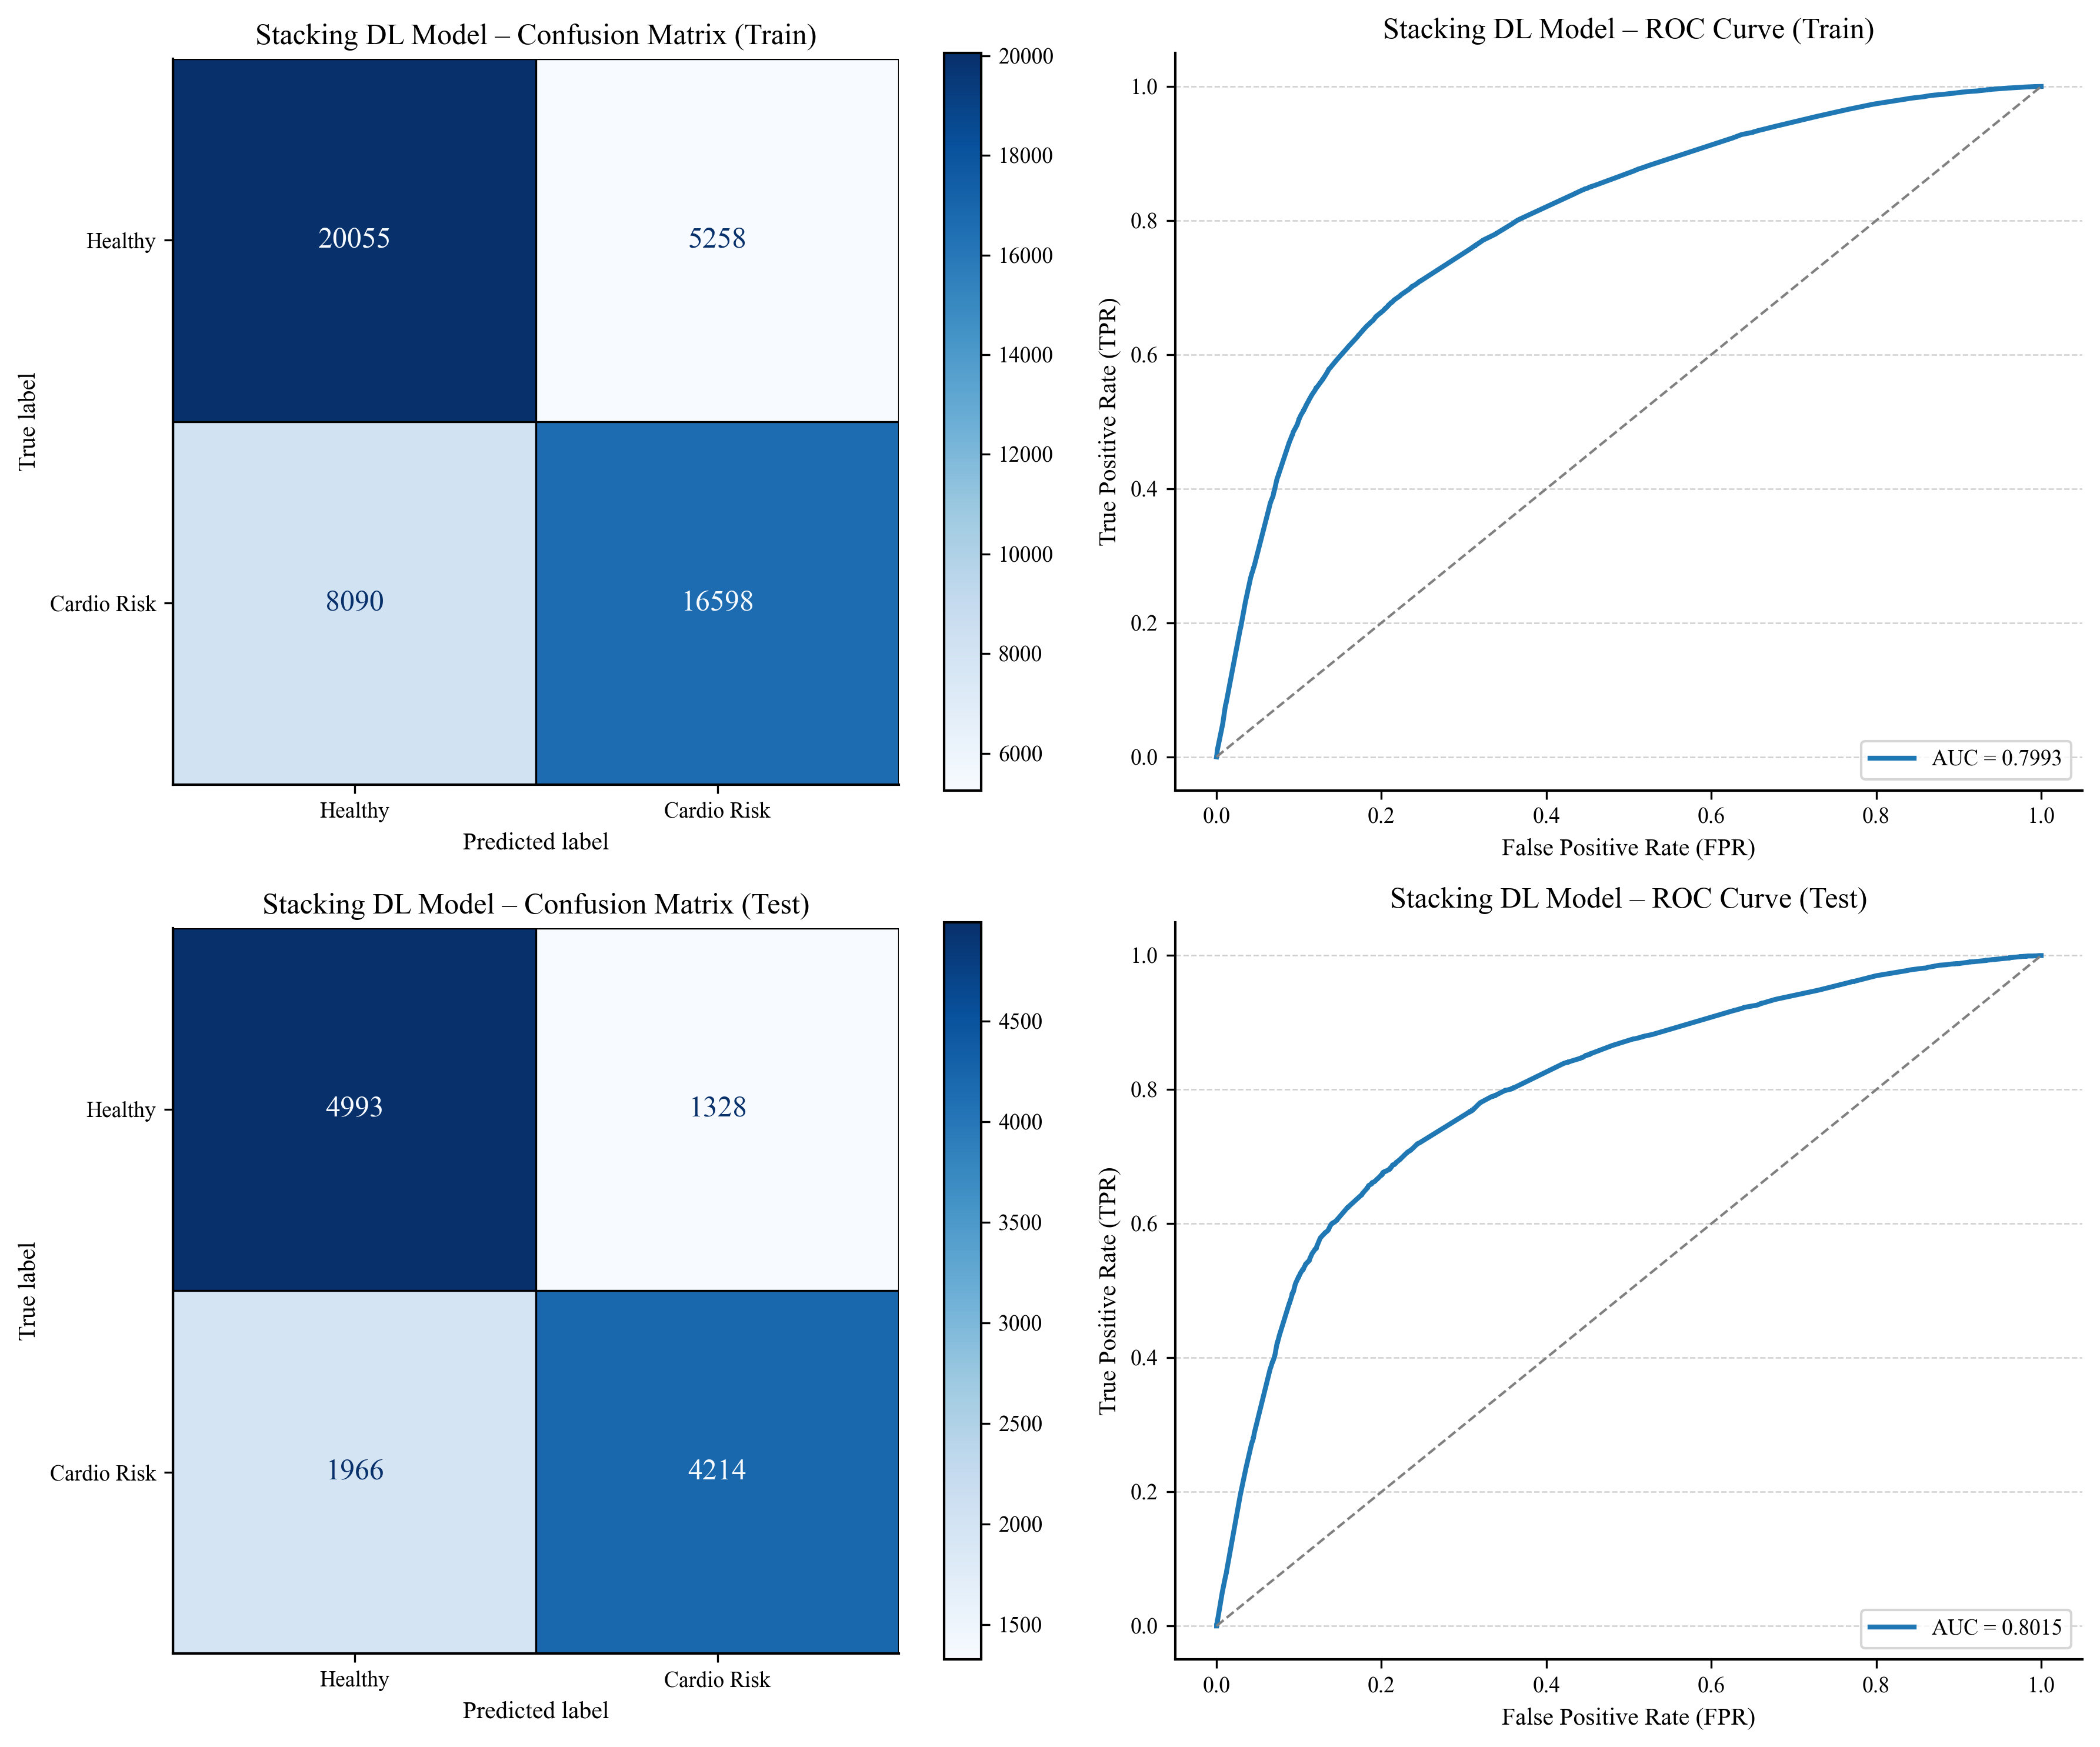

In [20]:
stacking_model_dl_results = evaluate_model(
    model               = stacking_model_dl,
    model_name          = "Stacking DL Model",
    plot_cm_roc         = True
    )

stacking_model_dl_results;

In [21]:
# stacking_model_hybird.fit(x_train_np, y_train_np)

In [22]:
# compare = {
#             'LightGBM': lgbm_model,
#             'CatBoost': catb_model,
#             'Hist Gradient Boosting' : hgrb_model,
#             'AdaBoost': adb_model,
#             'TabNet' : tabnet_model,
#             'TabTransformer': tabtf_wrapper,
#             'FT-Transformer': fttf_wrapper,
#             'Stacking ML Model': stacking_model_ml,
#             'Stacking DL Model': stacking_model_dl
#         }

# stacking_model_hybrid_results = evaluate_model(
#     model               = stacking_model_hybird,
#     model_name          = "Hybird Stacking Model",
#     plot_cm_roc         = True,
#     roc_auc             = compare,
#     plot_acc            = compare
#     )

# stacking_model_hybrid_results;


In [23]:
voting_ensemble = VotingClassifier(
    estimators=[
        ('stack_ml', stacking_model_ml),
        ('stack_dl', stacking_model_dl)
    ],
    voting='soft',  
    weights=[1, 1],    
    n_jobs=-1         
)

voting_ensemble.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

[Wrapper] Epoch 1/10, Loss: 0.5580
[Wrapper] Epoch 2/10, Loss: 0.5551
[Wrapper] Epoch 3/10, Loss: 0.5546
[Wrapper] Epoch 4/10, Loss: 0.5546
[Wrapper] Epoch 5/10, Loss: 0.5537
[Wrapper] Epoch 6/10, Loss: 0.5532
[Wrapper] Epoch 7/10, Loss: 0.5531
[Wrapper] Epoch 8/10, Loss: 0.5526
[Wrapper] Epoch 9/10, Loss: 0.5519
[Wrapper] Epoch 10/10, Loss: 0.5517
[Wrapper] Epoch 1/10, Loss: 0.5480
[Wrapper] Epoch 2/10, Loss: 0.5488
[Wrapper] Epoch 3/10, Loss: 0.5482
[Wrapper] Epoch 4/10, Loss: 0.5476
[Wrapper] Epoch 5/10, Loss: 0.5476
[Wrapper] Epoch 6/10, Loss: 0.5476
[Wrapper] Epoch 7/10, Loss: 0.5467
[Wrapper] Epoch 8/10, Loss: 0.5468
[Wrapper] Epoch 9/10, Loss: 0.5471
[Wrapper] Epoch 10/10, Loss: 0.5477


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5566
[Wrapper] Epoch 2/10, Loss: 0.5550
[Wrapper] Epoch 3/10, Loss: 0.5539
[Wrapper] Epoch 4/10, Loss: 0.5549
[Wrapper] Epoch 5/10, Loss: 0.5537
[Wrapper] Epoch 6/10, Loss: 0.5534
[Wrapper] Epoch 7/10, Loss: 0.5523
[Wrapper] Epoch 8/10, Loss: 0.5514
[Wrapper] Epoch 9/10, Loss: 0.5508
[Wrapper] Epoch 10/10, Loss: 0.5507
[Wrapper] Epoch 1/10, Loss: 0.5558
[Wrapper] Epoch 2/10, Loss: 0.5546
[Wrapper] Epoch 3/10, Loss: 0.5536
[Wrapper] Epoch 4/10, Loss: 0.5525
[Wrapper] Epoch 5/10, Loss: 0.5530
[Wrapper] Epoch 6/10, Loss: 0.5517
[Wrapper] Epoch 7/10, Loss: 0.5525
[Wrapper] Epoch 8/10, Loss: 0.5506
[Wrapper] Epoch 9/10, Loss: 0.5501
[Wrapper] Epoch 10/10, Loss: 0.5495
[Wrapper] Epoch 1/10, Loss: 0.5587
[Wrapper] Epoch 2/10, Loss: 0.5573
[Wrapper] Epoch 3/10, Loss: 0.5566
[Wrapper] Epoch 4/10, Loss: 0.5557
[Wrapper] Epoch 5/10, Loss: 0.5547
[Wrapper] Epoch 6/10, Loss: 0.5551
[Wrapper] Epoch 7/10, Loss: 0.5534
[Wrapper] Epoch 8/10, Loss: 0.5546
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('stack_ml',
                              StackingClassifier(cv=5,
                                                 estimators=[('lgbm',
                                                              LGBMClassifier(verbose=-1)),
                                                             ('cat',
                                                              <catboost.core.CatBoostClassifier object at 0x7538c236f9d0>),
                                                             ('hgrb',
                                                              HistGradientBoostingClassifier(random_state=42))],
                                                 final_estimator=AdaBoostClassifier(),
                                                 passthrough=True)),
                             ('stack_dl',
                              StackingClassifier(cv=5,
                                                 estimators=[('tabnet',...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                                                 final_estimator=AdaBoostClassifier(),
                                                 passthrough=True))],
                 n_jobs=-1, voting='soft', weights=[1, 1])


            === Hybird Voting Model Results ===             
Test Acc: 0.7405, AUC: 0.8017
              precision    recall  f1-score   support

           0     0.7257    0.7826    0.7531      6321
           1     0.7583    0.6974    0.7266      6180

    accuracy                         0.7405     12501
   macro avg     0.7420    0.7400    0.7398     12501
weighted avg     0.7418    0.7405    0.7400     12501

Train Acc: 0.7385, AUC: 0.8095
              precision    recall  f1-score   support

           0     0.7228    0.7843    0.7523     25313
           1     0.7577    0.6916    0.7232     24688

    accuracy                         0.7385     50001
   macro avg     0.7403    0.7380    0.7377     50001
weighted avg     0.7400    0.7385    0.7379     50001

✅ No significant overfitting



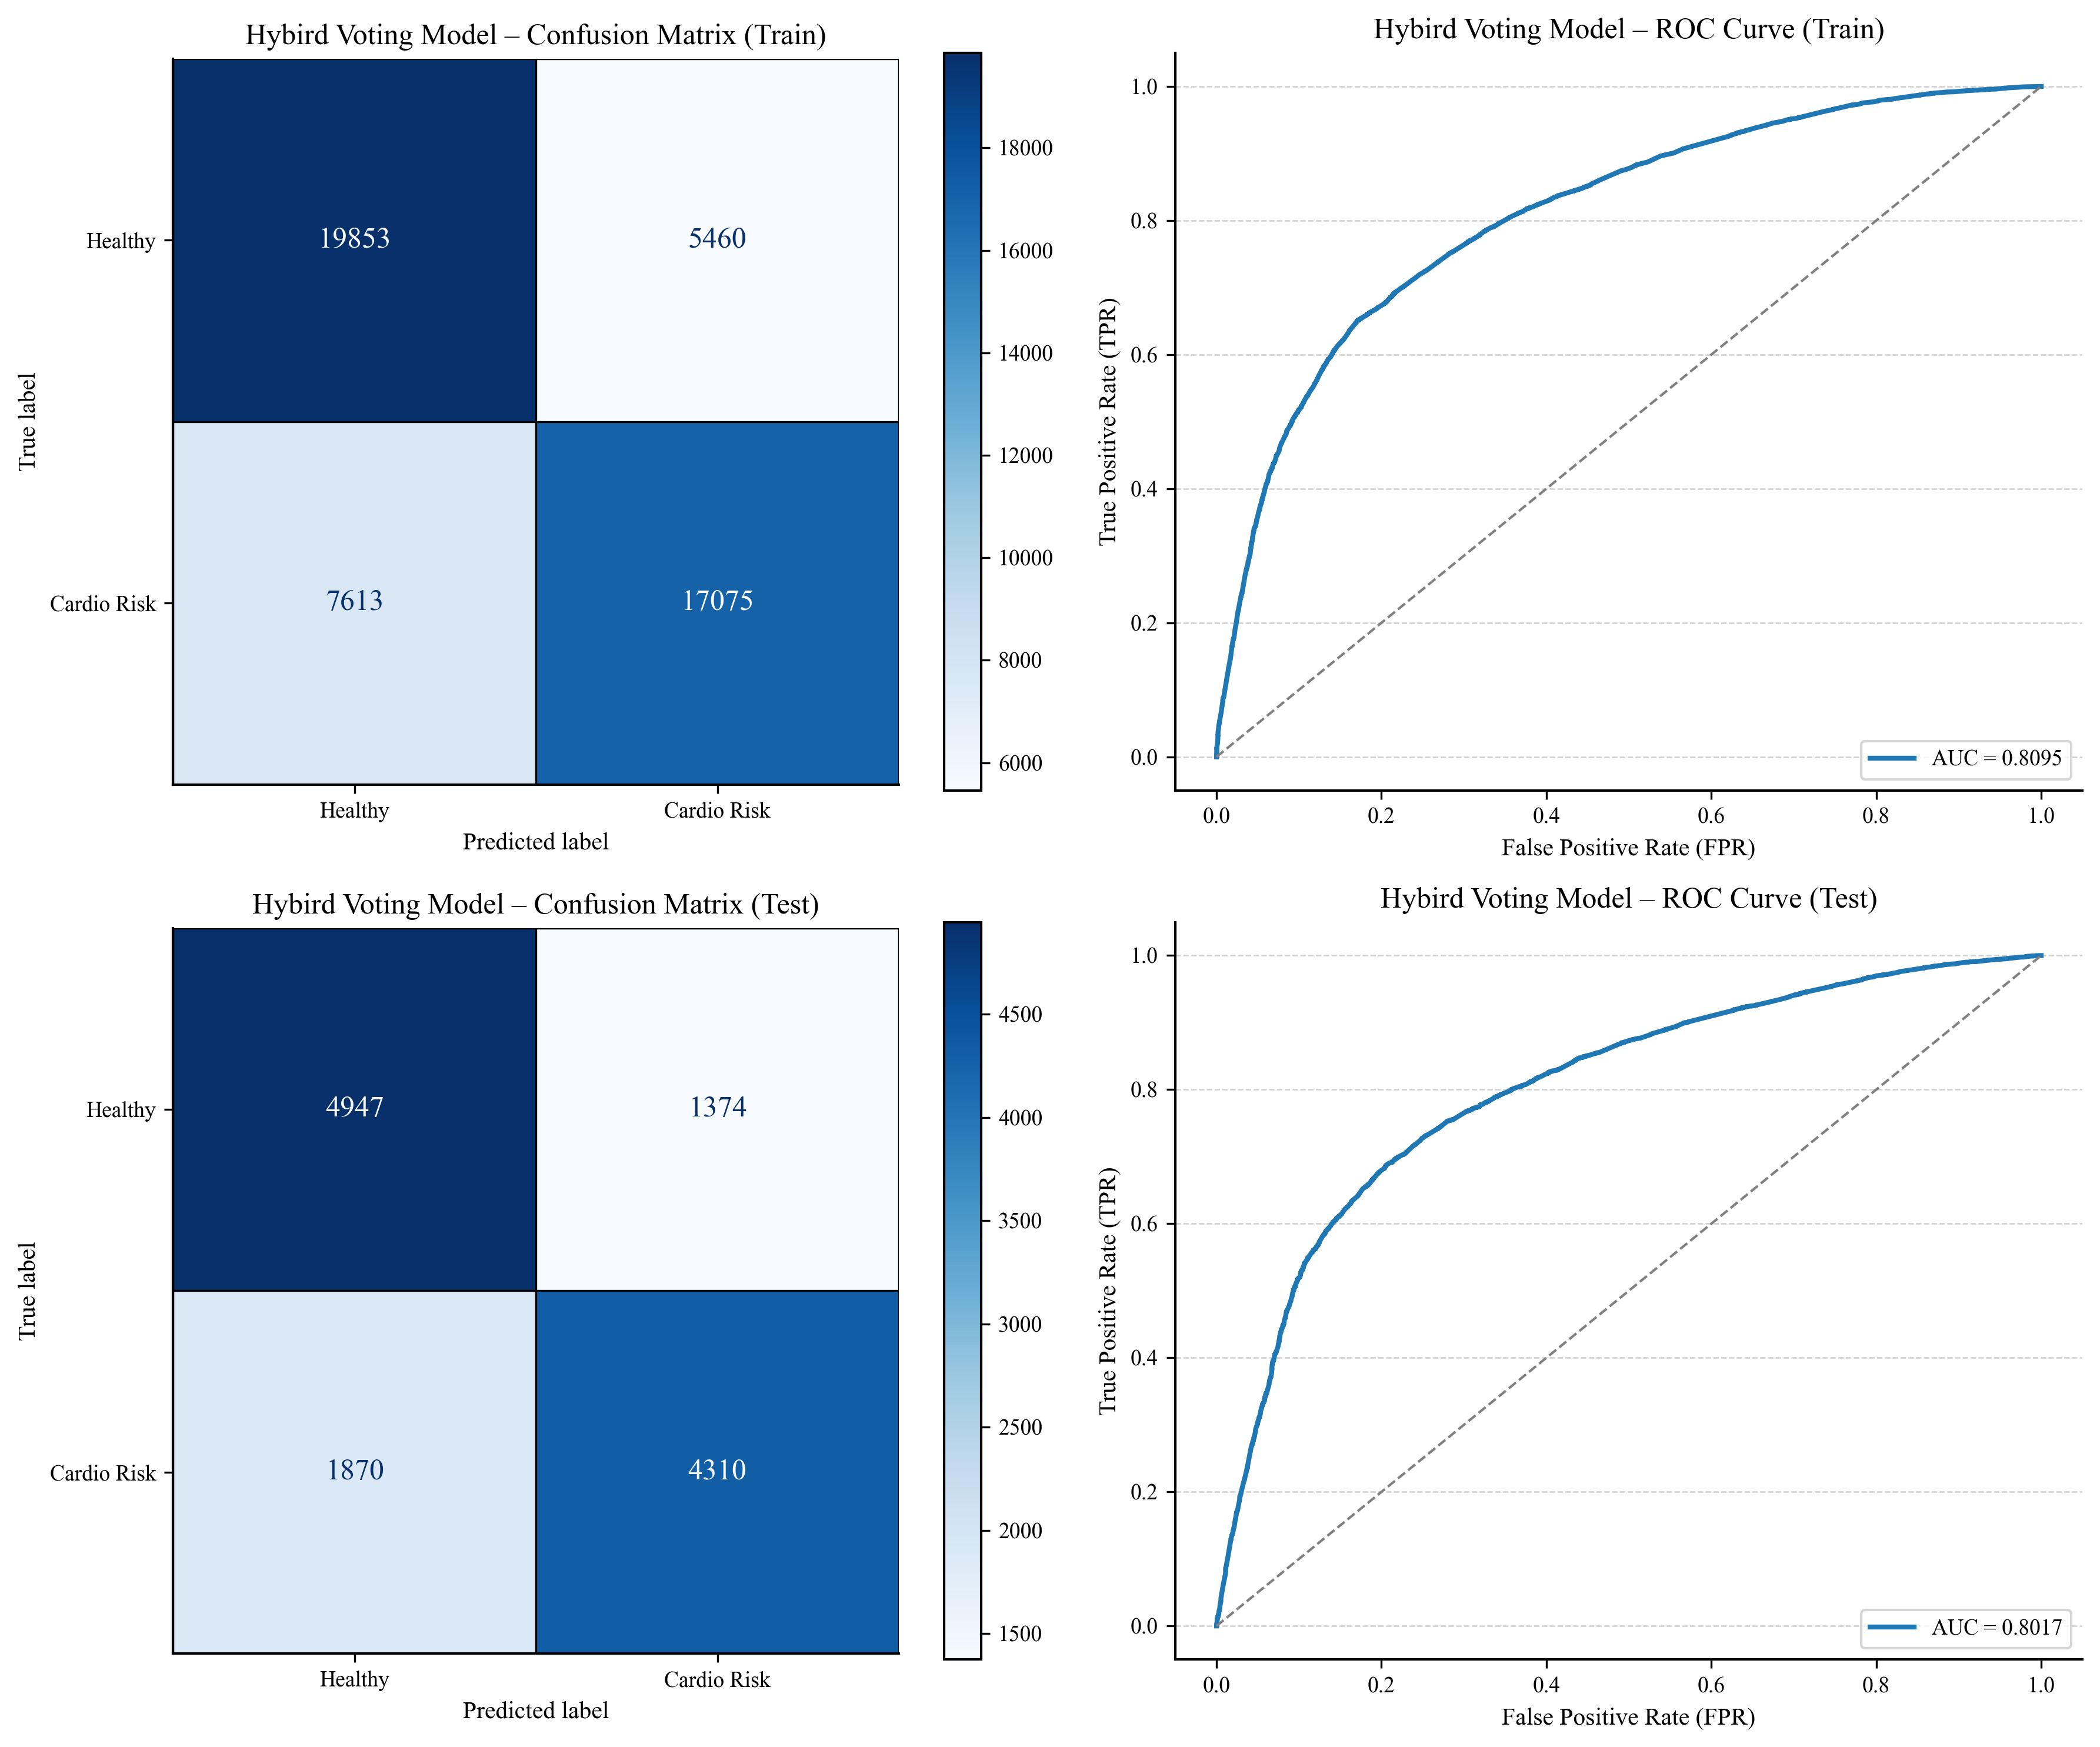

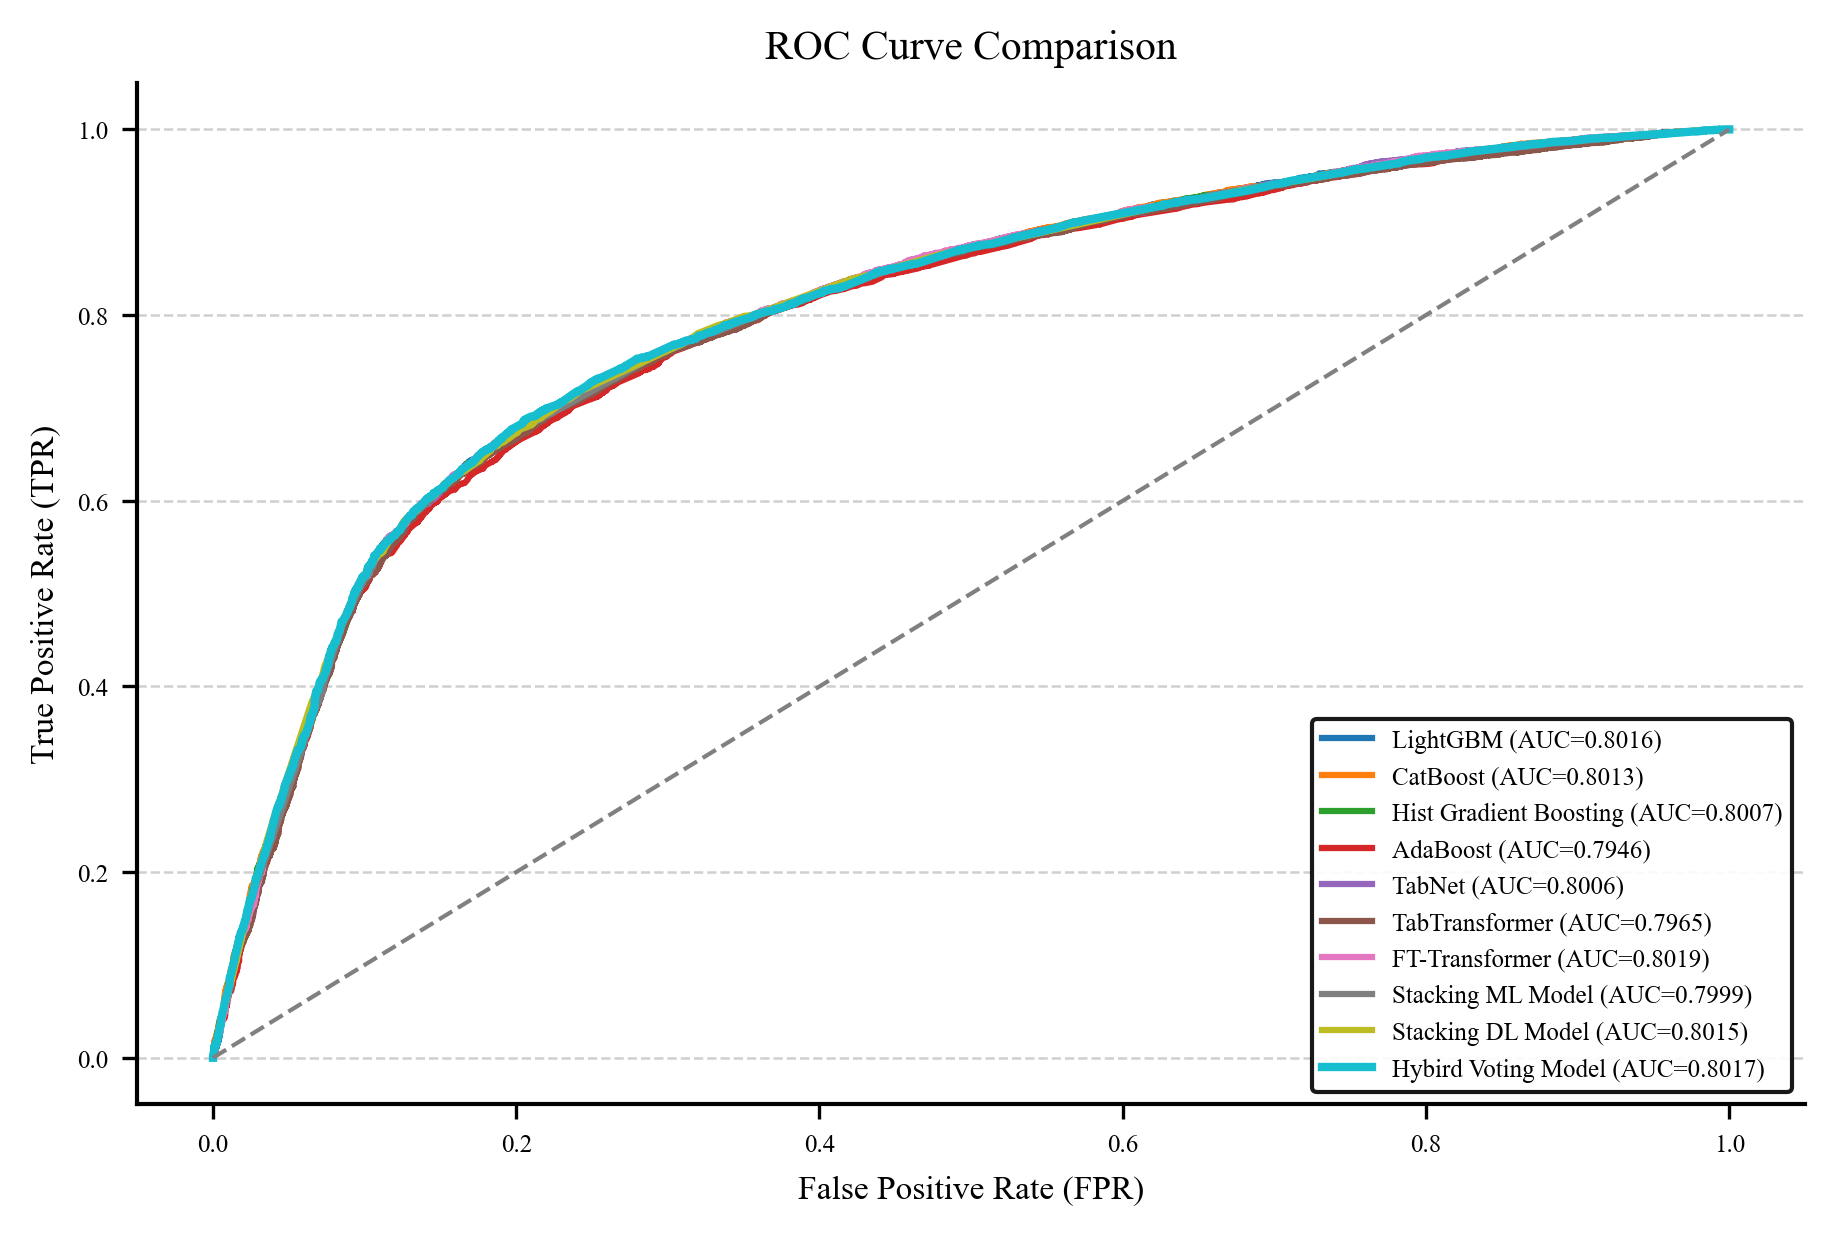

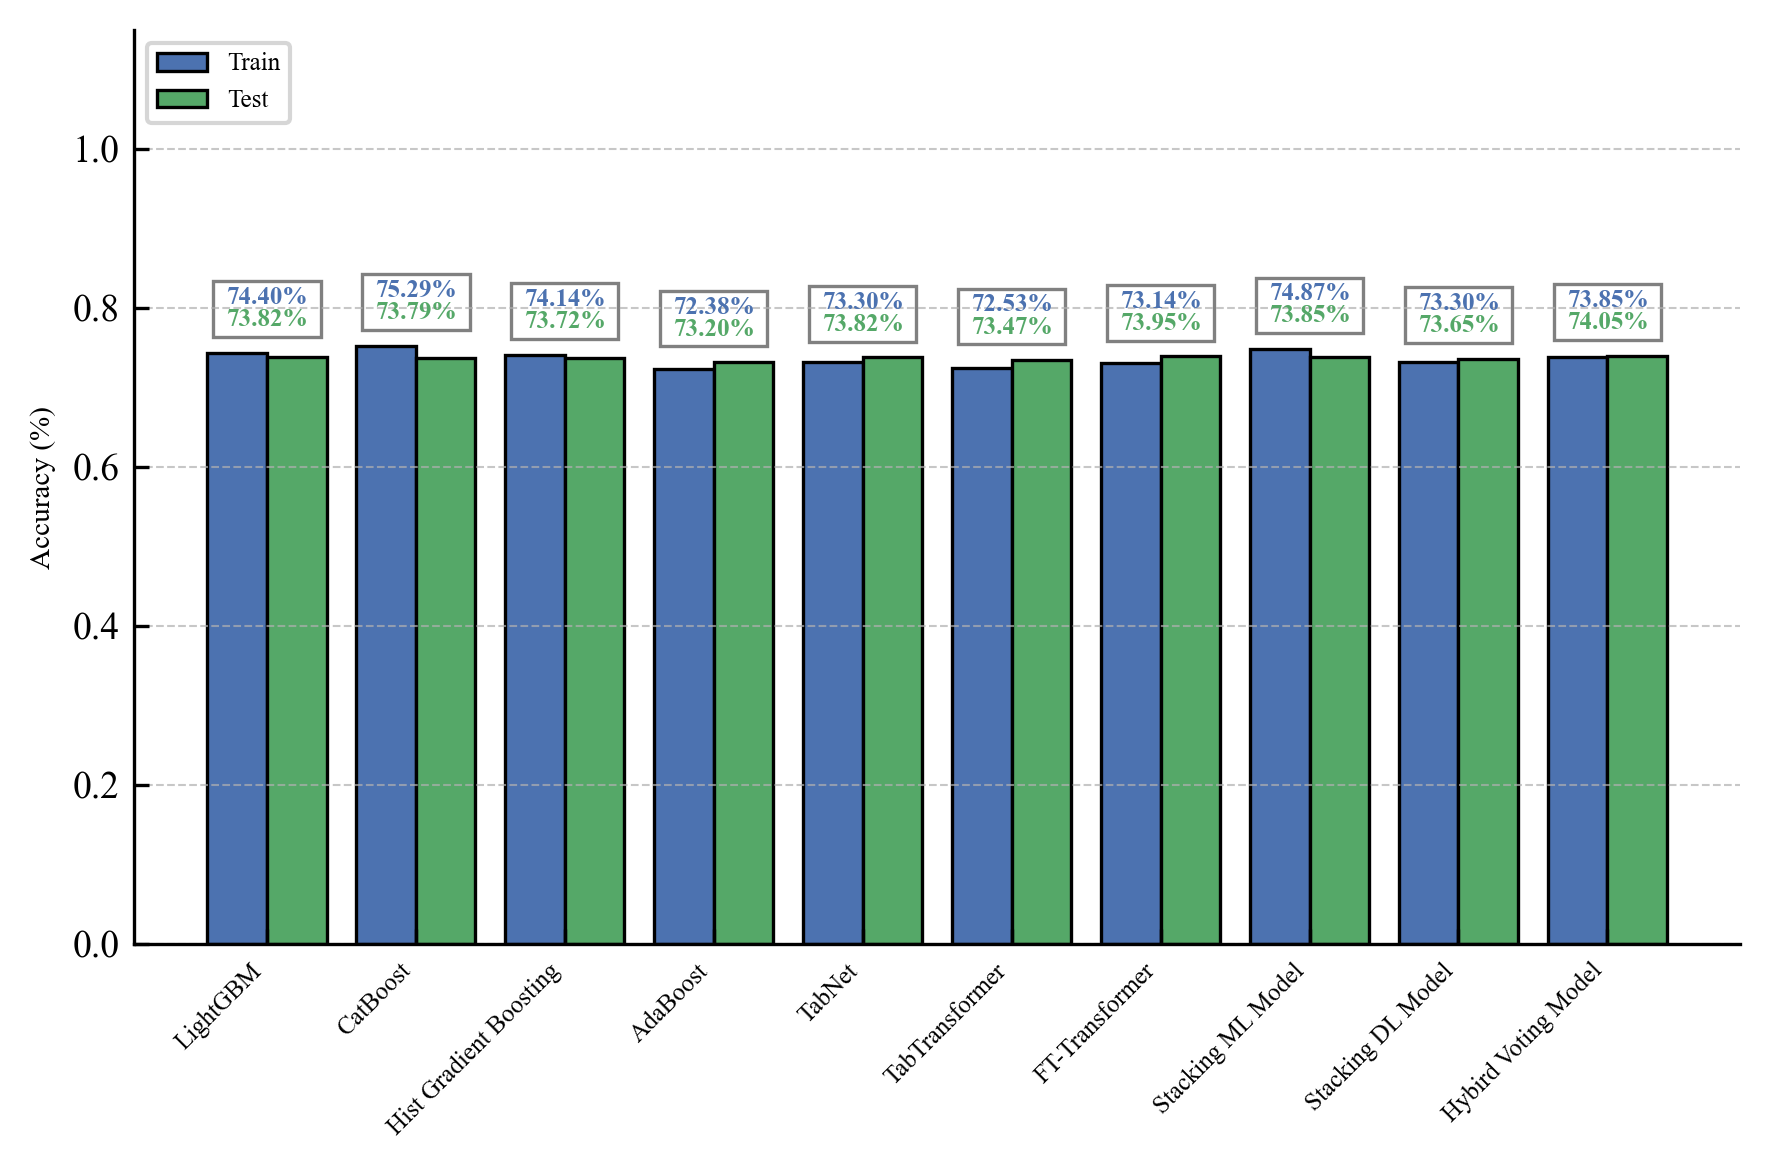

In [24]:
compare = {
            'LightGBM': lgbm_model,
            'CatBoost': catb_model,
            'Hist Gradient Boosting' : hgrb_model,
            'AdaBoost': adb_model,
            'TabNet' : tabnet_model,
            'TabTransformer': tabtf_wrapper,
            'FT-Transformer': fttf_wrapper,
            'Stacking ML Model': stacking_model_ml,
            'Stacking DL Model': stacking_model_dl
        }

voting_model_results = evaluate_model(
    model               = voting_ensemble,
    model_name          = "Hybird Voting Model",
    plot_cm_roc         = True,
    summary=compare,
    roc_auc             = compare,
    plot_acc            = compare
    )

voting_model_results;

In [25]:
# y_pred = stacking_model.predict(x_test_np)

# accuracy = accuracy_score(y_test_np, y_pred)
# report = classification_report(y_test_np, y_pred)

# print("Accuracy:", accuracy)
# print("\nClassification Report:\n", report)

In [26]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [27]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [28]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [29]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [30]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [31]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)